# Tasks

* explain data inputs
* impute n/a and missing data
* normalize the data
* look at data distributions
* look at column correlations
* remove correlated columns
* basic linear regression
* boosting model
* neural network model
* consider 2 models - 1 predicting residential and 1 predicting non-residential
* class imbalance

In [1]:
import tensorflow as tf

# Setup

In [1]:
#Import Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,\
StratifiedKFold,\
RandomizedSearchCV,\
GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

ModuleNotFoundError: No module named 'catboost'

In [14]:
#Define functions
#Set of functions for data cleaning
class clean():
    '''
    Functions used to clean data sets. 
    to_binary: convert features consisting of only yes/no values to a binary indicator
    identify_uniform: Remove columns that contain only one value (ignoring N/A)
    identify_diverse_cat: Identify and/or delete columns above a specified limit of unique values
    lable_encoding: Label encode categorical variables
    
    '''
    
    def to_binary(df):
        '''
        Convert features consisting of only yes/no values to a binary indicator
        to_binary(df) --> df with yes/no columns converted to 1/0
        '''
        for col in df:
            if len(df[col].unique() == 2) and not df[col].isna().values.any():
                if 'No' in df[col].unique() and 'Yes' in df[col].unique():
                    df[col] = np.where(df[col] == 'No', 0, 1)
                if 'FALSE' in df[col].unique() and 'TRUE' in df[col].unique():
                    df[col] = np.where(df[col] == 'FALSE', 0, 1)
        return(df)
    
    def convert_to_float_try_except(col):
        '''
        Convert variable to float, with try-except loop to catch any type errors and set errors to zero
        convert_to_float_try_except(df, col) --> df with column converted to float
        '''
        try:
            new_col = float(col)
        except ValueError:
            new_col = 0
        new_col = float(new_col)
        return(new_col)

    def identify_uniform(df):
        '''
        Identify features that contain only one value (ignoring N/A)
        identify_uniform(df) --> list of uniform columns
        '''
        uniform_vars = []
        for col in df.columns:
            if len((df[col][df[col] != 'nan']).value_counts()) <= 1:
                uniform_vars.append(col)
        print('The following features are uniform:\n', uniform_vars)
        
        return(uniform_vars)
    
    def identify_diverse_cat(df, limit, delete):
        '''
        Identify and/or delete columns above a specified limit of unique values
        identify_diverse_cat(df, limit, delete) --> df
        '''
        cat_cols = list(df.select_dtypes(exclude=[np.number]).columns.values)
        
        for col in cat_cols:
            num_unique = len(list(df[col].unique()))
            if num_unique >= limit:
                if delete:
                    df = df.drop([col], axis=1)
                    print(f'{col} column was deleted becuase it had {num_unique} categories')
                else:
                    print(f'{col} column has {num_unique} categories and should be binned or transformed')
        return(df)
                
    
    def label_encoding(df):
        '''
        Label encode categorical variables
        label_encoding(df) --> df with categorical features label encoded
        '''
        label_encoder = LabelEncoder()
        categorical_list = list(df.select_dtypes(exclude=[np.number]).columns)
        for col in categorical_list:
            df[col] = df[col].apply(str)
            df[col] = label_encoder.fit_transform(df[col])
        return(df)

#Set of functions for hyper parameter turning for CatBoost, XGBoost, and Random Forest models
class parameter_tuning():
    '''
    A set of functions to assist with hyper parameter tuning for models
    Functions: randomsearch, gridsearch
    '''
    def randomsearch(seed, x, y, random_grid, model):
        '''
        Run a random search on parameters for randomforest (model='rf'), xgboost (model='xgb'),
        and catboost (model='catboost') models
        randomsearch(seed, x, y, model) --> best_params
        '''
        if model == 'rf':
            estimator = RandomForestClassifier()         
            
        elif model == 'xgboost':
            estimator = XGBClassifier(loss_function='Logloss', random_seed=seed)
            
        elif model == 'catboost':
            estimator = CatBoostClassifier(loss_function='Logloss', random_seed=seed)
       
        strat_kfold = StratifiedKFold(n_splits = 4, shuffle = True, random_state = seed)
        scoring = make_scorer(recall_score)
        random_search = RandomizedSearchCV(estimator=estimator, param_distributions=random_grid,
                                           n_iter=100, cv=strat_kfold.split(x, y), verbose=3, random_state=seed,
                                           n_jobs=-1, scoring = scoring)
        random_search.fit(x, y)
        return(random_search.best_params_)
    
    def gridsearch(seed, x, y, random_grid, model):
        '''
        Run a full grid search on parameters for randomforest (model='rf'), xgboost (model='xgb'),
        and catboost (model='catboost') models
        gridsearch(seed, x, y, model) --> best_params
        '''
        if model == 'rf':
            estimator = RandomForestClassifier()

        elif model == 'xgboost':
            estimator = XGBClassifier()
            
        elif model == 'catboost':
            estimator = CatBoostClassifier()
       
        strat_kfold = StratifiedKFold(n_splits = 4, shuffle = True, random_state = seed)
        scoring = make_scorer(recall_score)
        grid_search = GridSearchCV(estimator=estimator, param_grid=random_grid, cv=strat_kfold.split(x, y),
                                   verbose=3, n_jobs=-1, scoring = scoring)
        grid_search.fit(x, y)
        return(grid_search.best_params_)

#Set of functions for Machine Learning models
class models():
    
    '''
    Define Machine Learning models
    Functions: catboost_model, rf_model
    Will use recall as the evaluation metric because the cost of a false negative is low and we need to capture all
    potential churners
    '''
    def catboost_model(x_train, x_test, y_train, y_test, seed, use_best_mod, **kwargs):
        '''
        Define CatBoost Model
        catboost_model(x_train, x_test, y_train, y_test, seed, use_best_mod, **kwargs) --> model
        '''
        combined = pd.concat([x_train, x_test])
        cat_feat_index = np.where(combined.dtypes == object)[0]
        model = CatBoostClassifier(**kwargs, use_best_model=True,
                                       loss_function='Logloss', eval_metric='Recall', random_seed=seed)
            
        model.fit(x_train, y_train, plot=True, cat_features=cat_feat_index, eval_set=(x_test, y_test))
        
        return(model)
    
    def rf_model(x_cat_train, y_cat_train, seed, **kwargs):
        '''
        Define Random Forest Model
        rf_model(x_cat_train, y_cat_train, seed, **kwargs) --> model
        '''
        rf_mod = RandomForestClassifier(random_state=seed, **kwargs)
        rf_mod.fit(x_cat_train, y_cat_train)
        
        return(rf_mod)
    
    def xgboost_model(x_cat_train, y_cat_train, seed, **kwargs):
        '''
        Define XGBoost Model
        xgb_model(x_cat_train, y_cat_train, seed, **kwargs) -->
        '''
        xgb = XGBClassifier(random_state=seed, **kwargs)
        xgb.fit(x_cat_train, y_cat_train)
        return(xgb)

#Set of functions to evaluate model performance
class evaluation():
    '''
    A set of functions to evaluate model performance
    Functions: predictions, scores, results
    '''
    def predictions(model, x_train, x_test):
        '''
        Use model to predict y test and train
        predictions(mode, x_train, x_test) --> y_pred_train, y_pred_test
        '''
        y_pred_train = model.predict(x_train)
        y_pred_test = model.predict(x_test)

        return(y_pred_train, y_pred_test)

    def scores(y, y_pred):
        '''
        Get model metrics
        scores(y, y_pred) --> AUC, accuracy, F1, recall, precision
        '''
        AUC = roc_auc_score(y, y_pred)
        accuracy = accuracy_score(y, y_pred)
        F1 = f1_score(y, y_pred)
        recall = recall_score(y, y_pred)
        precision = precision_score(y, y_pred)
        return(AUC, accuracy, F1, recall, precision)
    
    def results(y_train, y_test, y_pred_train, y_pred_test):
        '''
        Create train and test model metrics table
        results(y_train, y_test, y_pred_train, y_pred_test) --> final_results table
        '''
        AUC_test, accuracy_test, F1_test, recall_test, precision_test = evaluation.scores(y_test, y_pred_test)
        AUC_train, accuracy_train, F1_train, recall_train, precision_train = evaluation.scores(y_train, y_pred_train)
        final_results = {'Test': [AUC_test, accuracy_test, F1_test, recall_test, precision_test],
                        'Train': [AUC_train, accuracy_train, F1_train, recall_train, precision_train],
                        'Index Title': ['AUC','Accuracy', 'F1', 'Recall', 'Precision']}
        final_results = pd.DataFrame(final_results)
        final_results.index = final_results['Index Title']
        final_results.index.name = 'Metrics'
        del final_results['Index Title']
        return(final_results)    


# Data Cleaning and Preparation

In [3]:
#Read in data
df = pd.read_csv('/Users/gabbynyirjesy/Downloads/deepsolar_tract.csv',encoding='cp1252')
#Print an overview of the data set
df.head()

,Unnamed: 0,tile_count,solar_system_count,total_panel_area,fips,average_household_income,county,education_bachelor,education_college,education_doctoral,...,incentive_count_nonresidential,incentive_residential_state_level,incentive_nonresidential_state_level,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate
0,0,0.0,0.0,0.000000,27145011200,70352.789869,Stearns County,569,1690,13,...,39,11,13,34,0,0,25,12,0,9.46
1,1,25.0,21.0,1133.436461,27145011301,61727.085202,Stearns County,674,1434,108,...,39,11,13,34,0,0,25,12,0,9.46
2,2,3.0,3.0,64.505776,27145011302,71496.886583,Stearns County,854,1459,31,...,39,11,13,34,0,0,25,12,0,9.46
3,3,0.0,0.0,0.000000,27145011304,86840.152755,Stearns County,640,1116,68,...,39,11,13,34,0,0,25,12,0,9.46
4,4,5.0,5.0,164.583303,27145011400,89135.315597,Stearns County,654,1314,15,...,39,11,13,34,0,0,25,12,0,9.46


In [4]:
#Explore columns and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72537 entries, 0 to 72536
Columns: 169 entries, Unnamed: 0 to avg_electricity_retail_rate
dtypes: bool(2), float64(117), int64(47), object(3)
memory usage: 92.6+ MB


In [5]:
#Print list of categorical columns
cat_cols = list(df.select_dtypes(exclude=[np.number]).columns.values)
cat_cols

['county',
 'state',
 'electricity_price_transportation',
 'voting_2016_dem_win',
 'voting_2012_dem_win']

In [6]:
#Print list of numeric columns
numeric_cols = list(df.select_dtypes(include=[np.number]).columns.values)
numeric_cols

['Unnamed: 0',
 'tile_count',
 'solar_system_count',
 'total_panel_area',
 'fips',
 'average_household_income',
 'education_bachelor',
 'education_college',
 'education_doctoral',
 'education_high_school_graduate',
 'education_less_than_high_school',
 'education_master',
 'education_population',
 'education_professional_school',
 'employed',
 'gini_index',
 'heating_fuel_coal_coke',
 'heating_fuel_electricity',
 'heating_fuel_fuel_oil_kerosene',
 'heating_fuel_gas',
 'heating_fuel_housing_unit_count',
 'heating_fuel_none',
 'heating_fuel_other',
 'heating_fuel_solar',
 'land_area',
 'per_capita_income',
 'population',
 'population_density',
 'poverty_family_below_poverty_level',
 'poverty_family_count',
 'race_asian',
 'race_black_africa',
 'race_indian_alaska',
 'race_islander',
 'race_other',
 'race_two_more',
 'race_white',
 'total_area',
 'unemployed',
 'water_area',
 'education_less_than_high_school_rate',
 'education_high_school_graduate_rate',
 'education_college_rate',
 'educat

In [9]:
#Identify any uniform features. 
#If any features are returned, remove them from the data as they will not add any predictiveness
uniform_cols = clean.identify_uniform(df)

The following features are uniform:
 []


In [10]:
#Identify categorical features with more than 100 unique values.
#Consider binning, deleting, or converting to a continuous numeric variable
df = clean.identify_diverse_cat(df, 100, delete=False)

county column has 1843 categories and should be binned or transformed


In [12]:
#As seen above, the customerID column is very diverse, and will not add predictiveness to the model.
#Therefore, we will drop the customerID column
df_new = df.drop(['county'], axis=1)

In [13]:
#Examine data
df_new.head()

,Unnamed: 0,tile_count,solar_system_count,total_panel_area,fips,average_household_income,education_bachelor,education_college,education_doctoral,education_high_school_graduate,...,incentive_count_nonresidential,incentive_residential_state_level,incentive_nonresidential_state_level,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate
0,0,0.0,0.0,0.000000,27145011200,70352.789869,569,1690,13,1757,...,39,11,13,34,0,0,25,12,0,9.46
1,1,25.0,21.0,1133.436461,27145011301,61727.085202,674,1434,108,767,...,39,11,13,34,0,0,25,12,0,9.46
2,2,3.0,3.0,64.505776,27145011302,71496.886583,854,1459,31,1541,...,39,11,13,34,0,0,25,12,0,9.46
3,3,0.0,0.0,0.000000,27145011304,86840.152755,640,1116,68,1095,...,39,11,13,34,0,0,25,12,0,9.46
4,4,5.0,5.0,164.583303,27145011400,89135.315597,654,1314,15,982,...,39,11,13,34,0,0,25,12,0,9.46


From examining data, it is clear that there are several columns containing only "Yes/No" values that can 
be converted to "1/0". Use the to_binary function to convert those columns below.

In [15]:
df_new = clean.to_binary(df_new)

/var/folders/8w/yzz7q0p146x4qrt7dwp0mhy40000gn/T/ipykernel_2107/571162584.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'No' in df[col].unique() and 'Yes' in df[col].unique():
/var/folders/8w/yzz7q0p146x4qrt7dwp0mhy40000gn/T/ipykernel_2107/571162584.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'FALSE' in df[col].unique() and 'TRUE' in df[col].unique():


In [16]:
#As seen below, the "Yes/No" columns have been converted to binary
df_new.head()

,Unnamed: 0,tile_count,solar_system_count,total_panel_area,fips,average_household_income,education_bachelor,education_college,education_doctoral,education_high_school_graduate,...,incentive_count_nonresidential,incentive_residential_state_level,incentive_nonresidential_state_level,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate
0,0,0.0,0.0,0.000000,27145011200,70352.789869,569,1690,13,1757,...,39,11,13,34,0,0,25,12,0,9.46
1,1,25.0,21.0,1133.436461,27145011301,61727.085202,674,1434,108,767,...,39,11,13,34,0,0,25,12,0,9.46
2,2,3.0,3.0,64.505776,27145011302,71496.886583,854,1459,31,1541,...,39,11,13,34,0,0,25,12,0,9.46
3,3,0.0,0.0,0.000000,27145011304,86840.152755,640,1116,68,1095,...,39,11,13,34,0,0,25,12,0,9.46
4,4,5.0,5.0,164.583303,27145011400,89135.315597,654,1314,15,982,...,39,11,13,34,0,0,25,12,0,9.46


In [17]:
#Check to see if there are any N/A's remaining in the data (may need to impute)
df_new.isna().values.any()

True

In [18]:
#Check to see if there are any null values remaining in the data (may need to impute)
df_new.isnull().values.any()

True

In [19]:
#Print numeric columns
numeric_cols = list(df.select_dtypes(include=[np.number]).columns.values)
numeric_cols

['Unnamed: 0',
 'tile_count',
 'solar_system_count',
 'total_panel_area',
 'fips',
 'average_household_income',
 'education_bachelor',
 'education_college',
 'education_doctoral',
 'education_high_school_graduate',
 'education_less_than_high_school',
 'education_master',
 'education_population',
 'education_professional_school',
 'employed',
 'gini_index',
 'heating_fuel_coal_coke',
 'heating_fuel_electricity',
 'heating_fuel_fuel_oil_kerosene',
 'heating_fuel_gas',
 'heating_fuel_housing_unit_count',
 'heating_fuel_none',
 'heating_fuel_other',
 'heating_fuel_solar',
 'land_area',
 'per_capita_income',
 'population',
 'population_density',
 'poverty_family_below_poverty_level',
 'poverty_family_count',
 'race_asian',
 'race_black_africa',
 'race_indian_alaska',
 'race_islander',
 'race_other',
 'race_two_more',
 'race_white',
 'total_area',
 'unemployed',
 'water_area',
 'education_less_than_high_school_rate',
 'education_high_school_graduate_rate',
 'education_college_rate',
 'educat

In [21]:
test = df[-df.isna()]

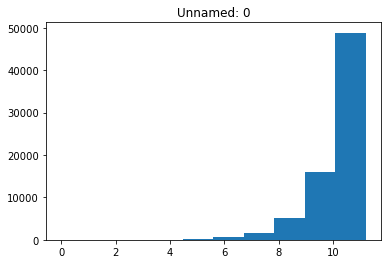

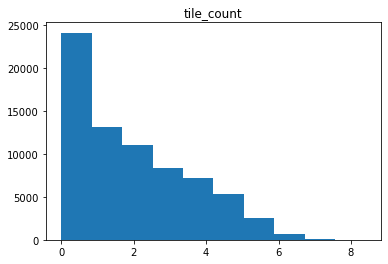

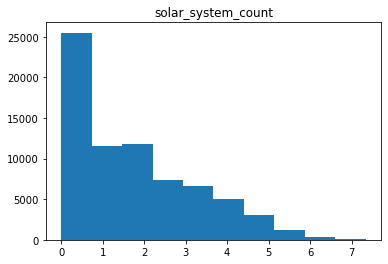

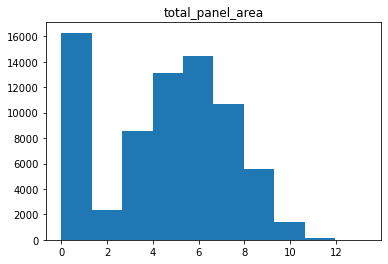

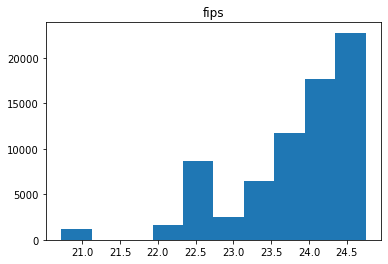

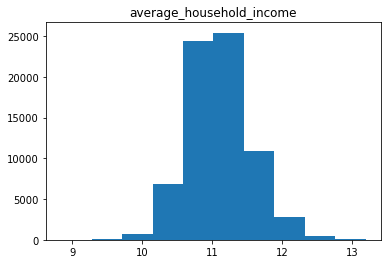

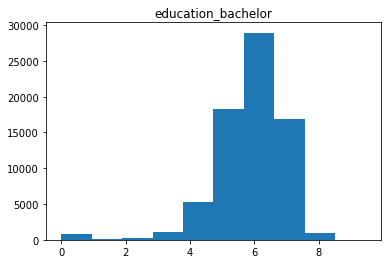

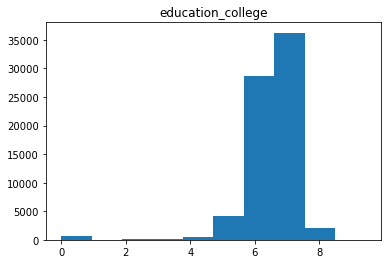

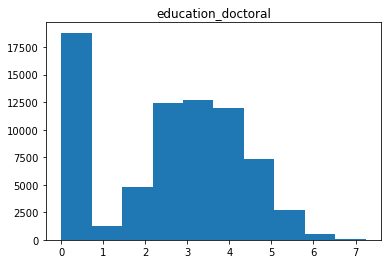

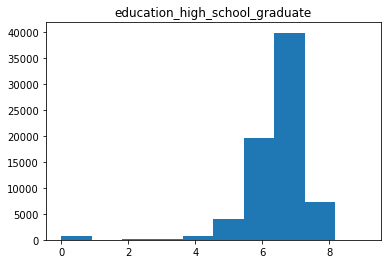

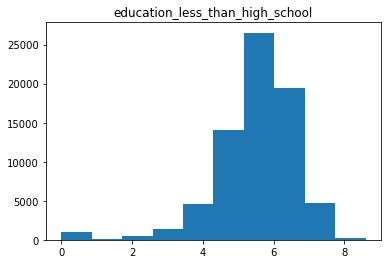

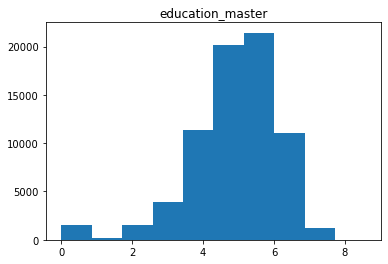

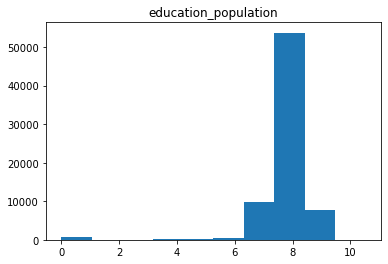

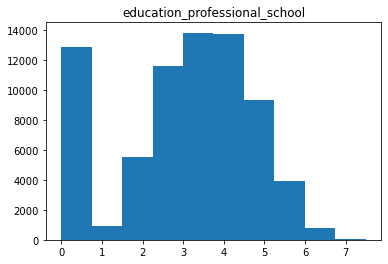

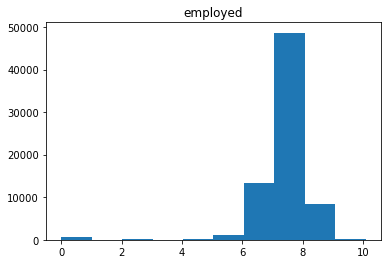

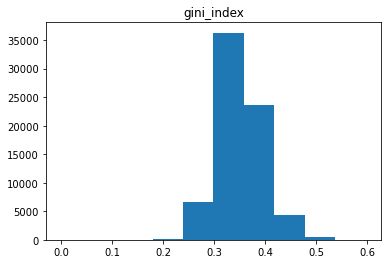

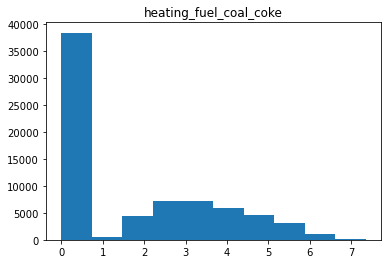

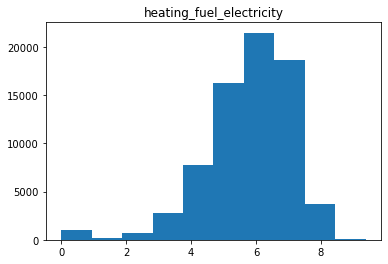

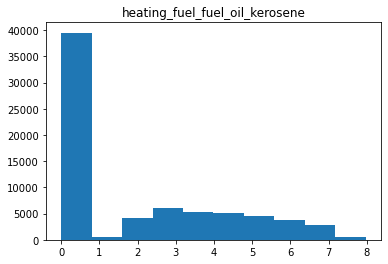

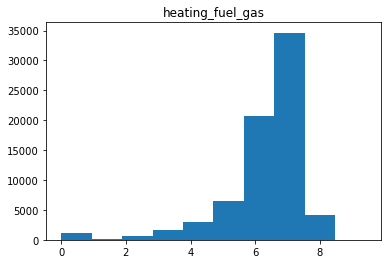

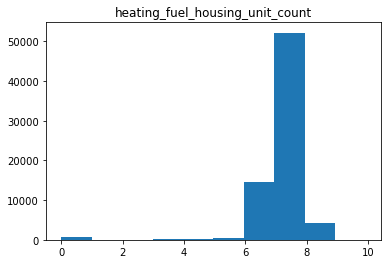

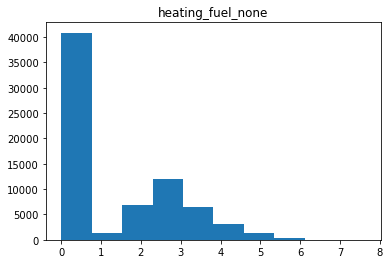

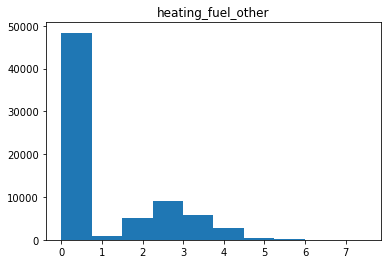

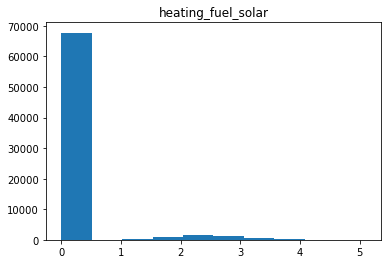

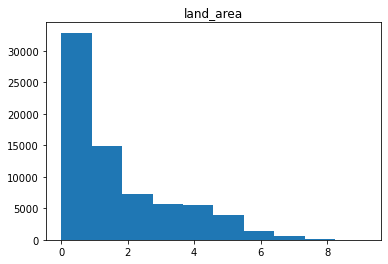

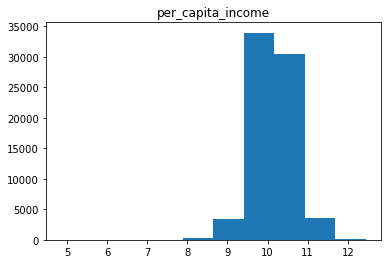

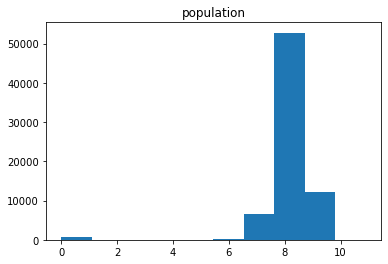

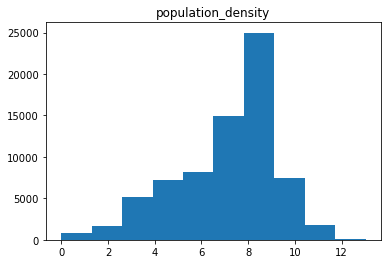

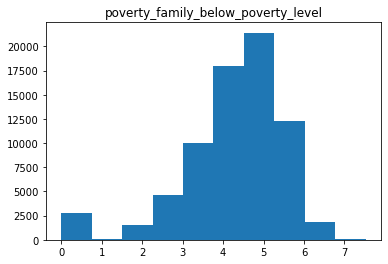

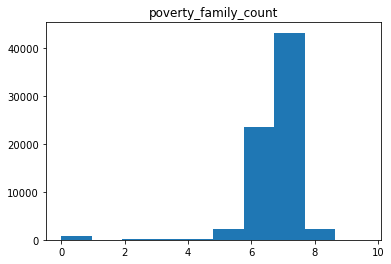

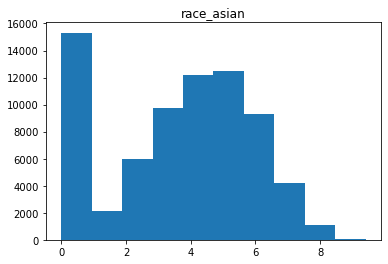

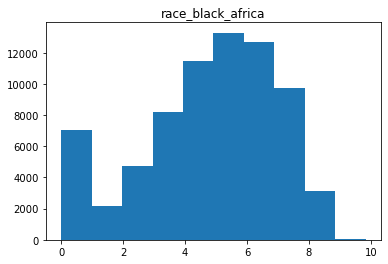

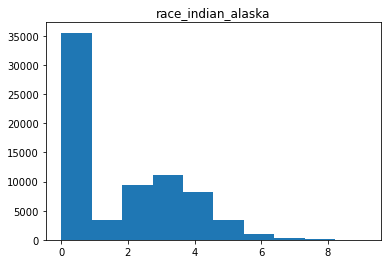

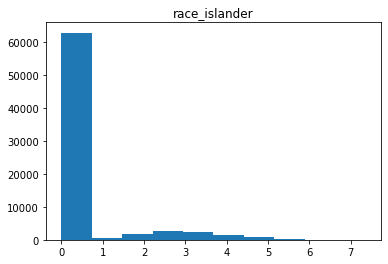

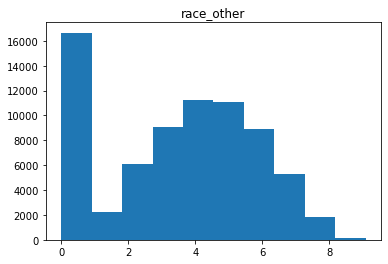

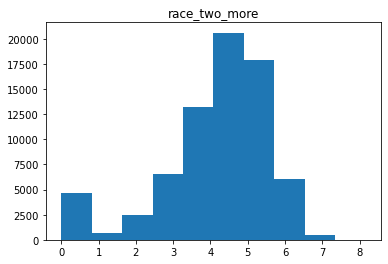

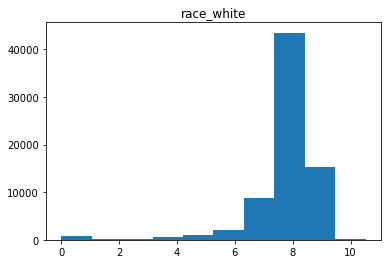

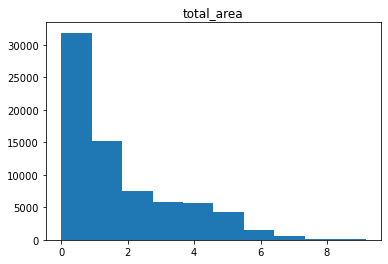

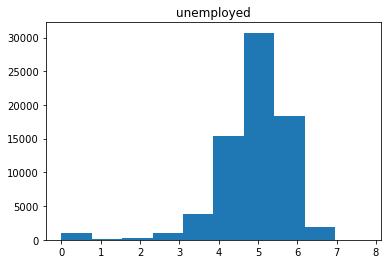

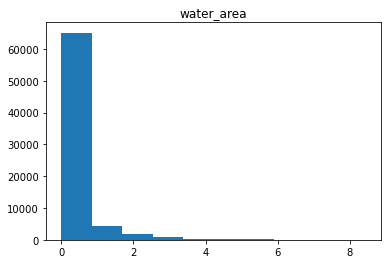

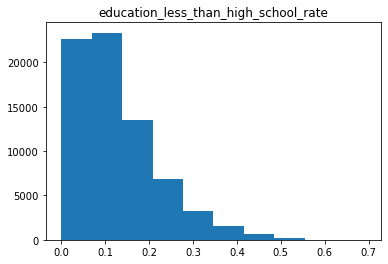

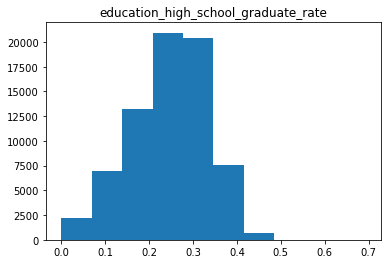

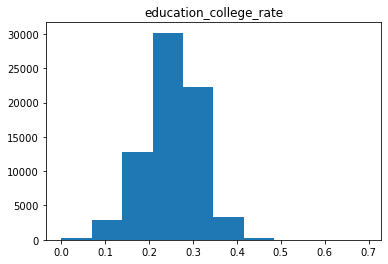

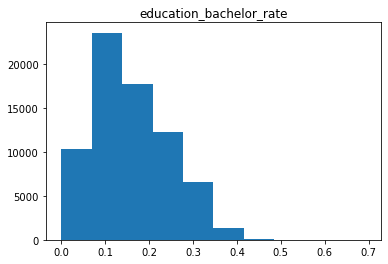

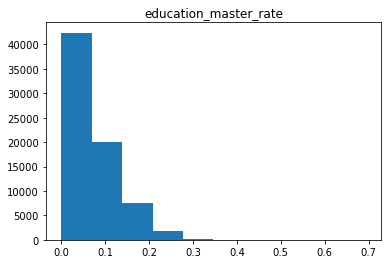

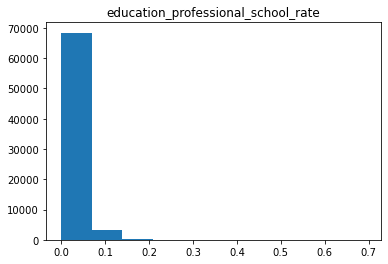

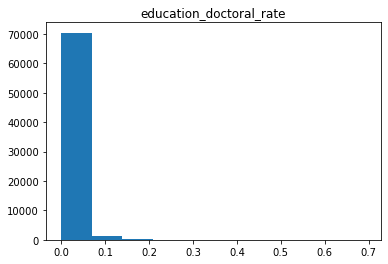

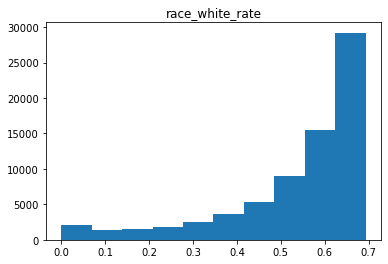

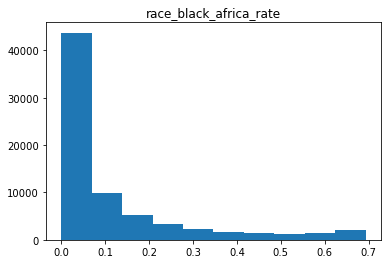

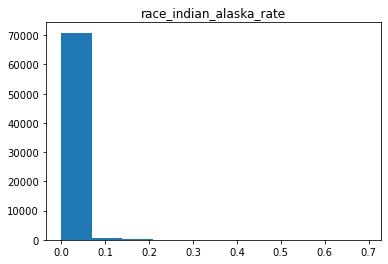

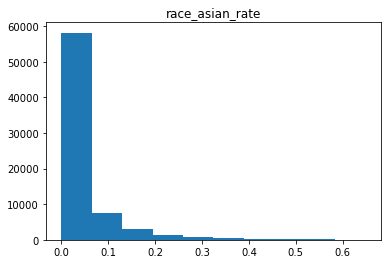

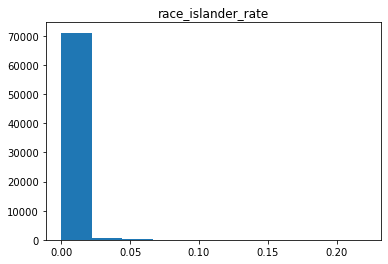

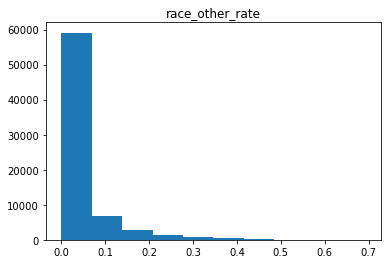

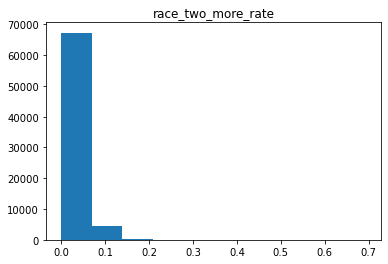

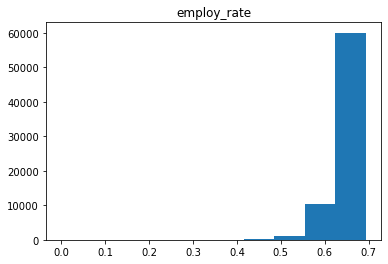

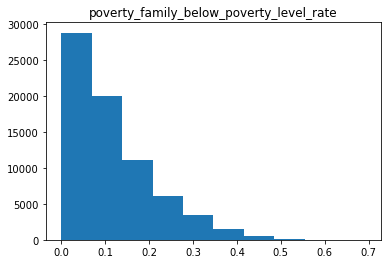

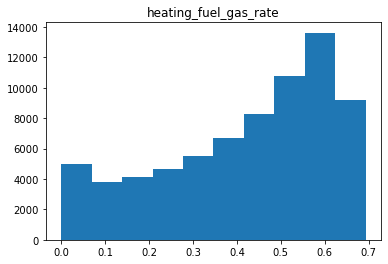

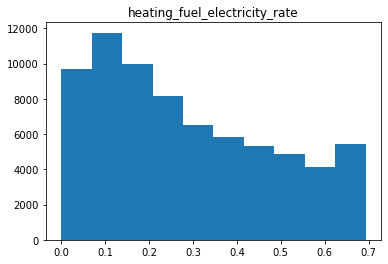

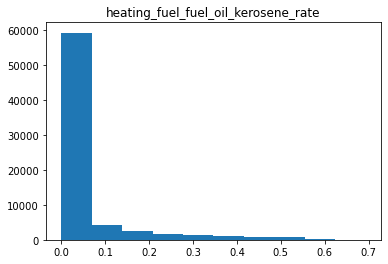

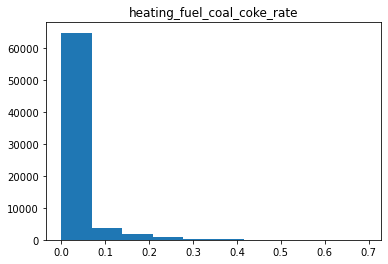

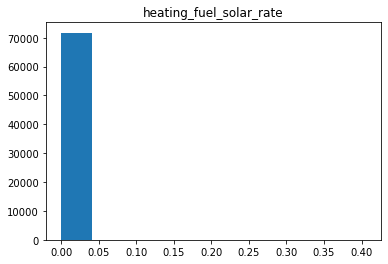

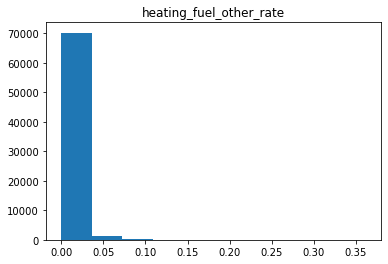

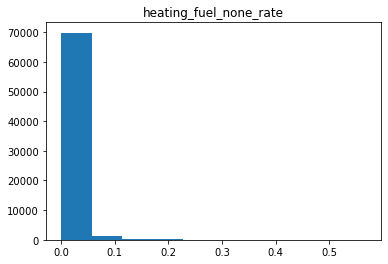

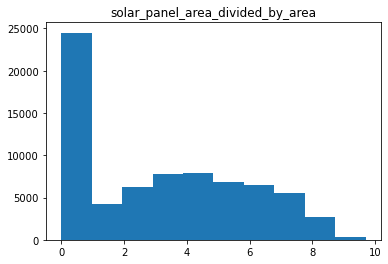

solar_panel_area_per_capita  did not plot


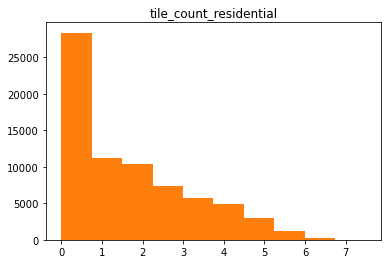

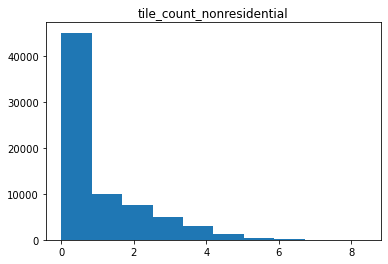

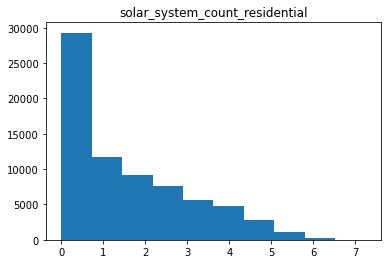

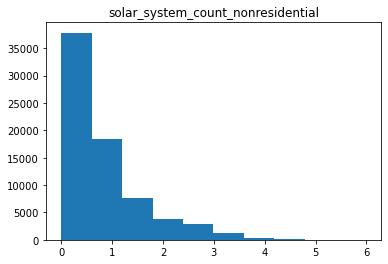

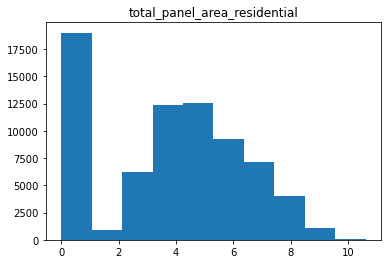

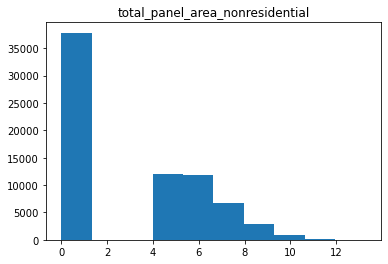

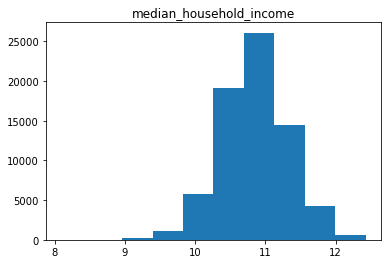

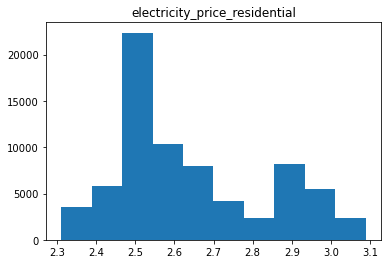

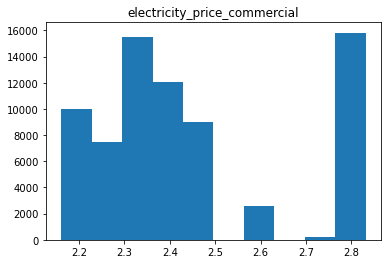

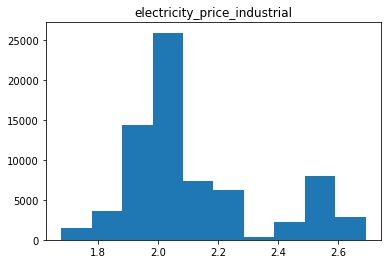

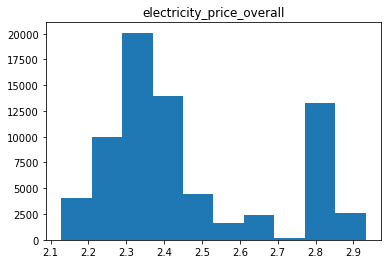

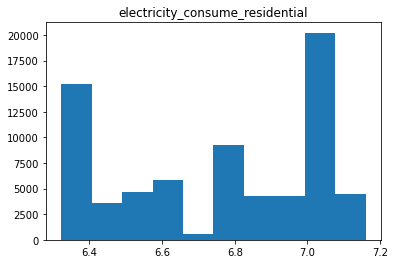

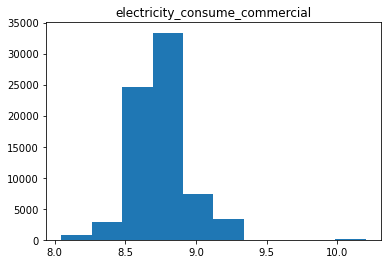

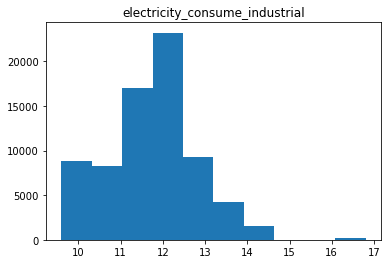

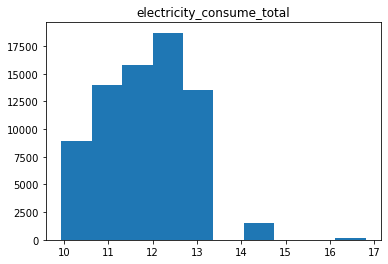

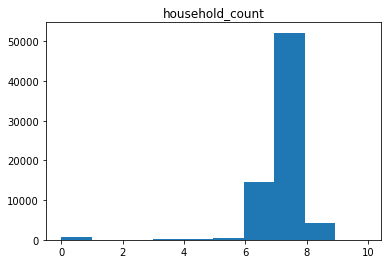

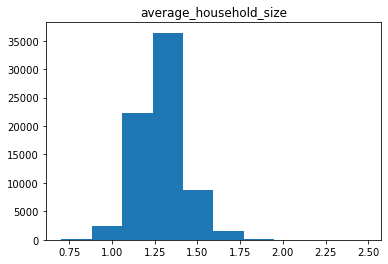

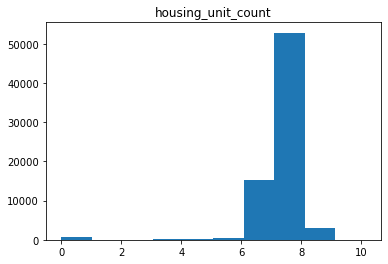

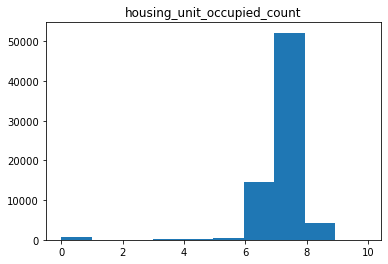

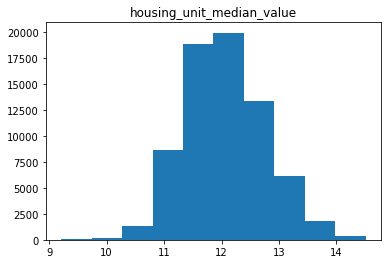

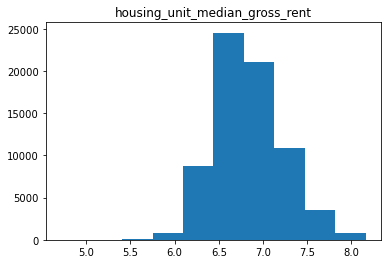

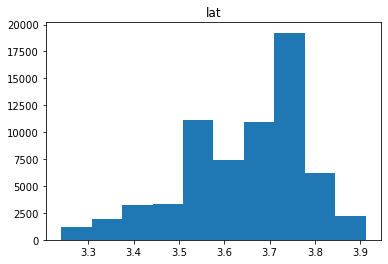

lon  did not plot


/opt/anaconda3/envs/mlenv/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6731: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/opt/anaconda3/envs/mlenv/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6732: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


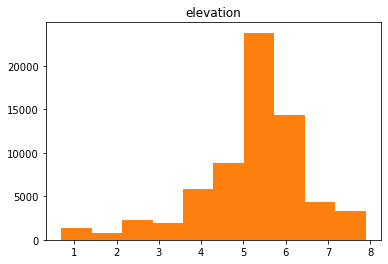

heating_design_temperature  did not plot


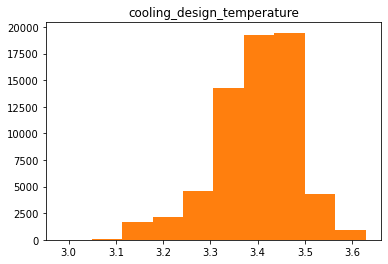

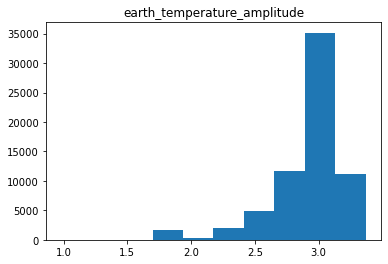

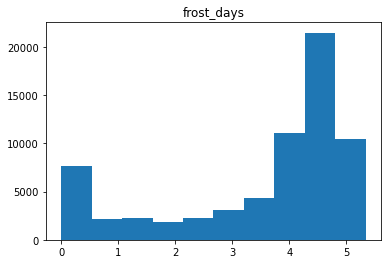

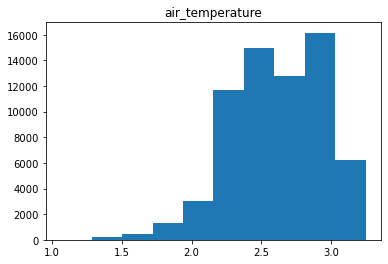

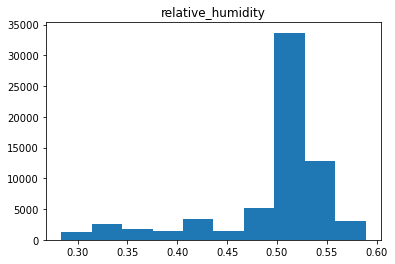

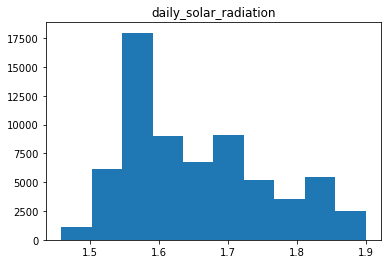

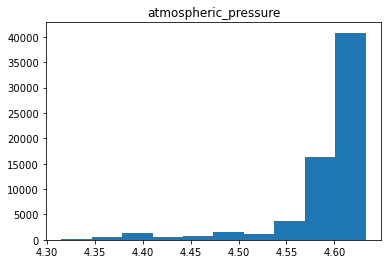

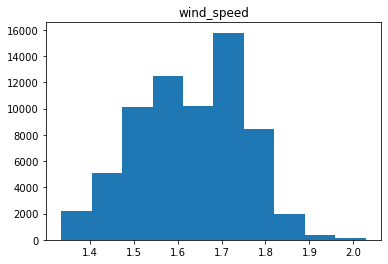

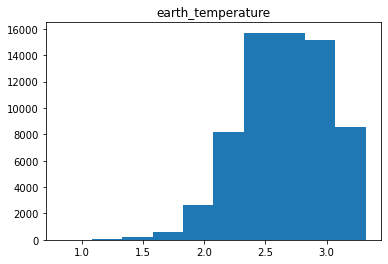

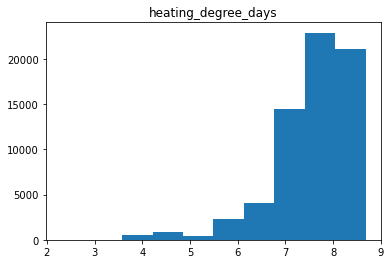

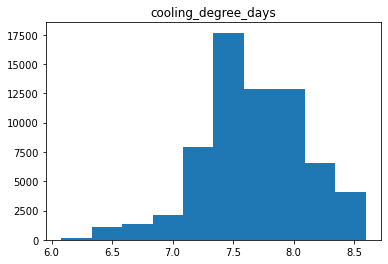

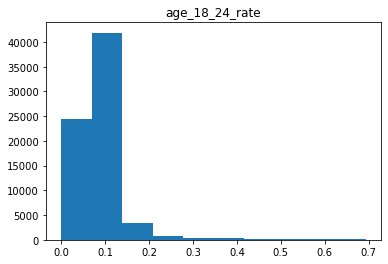

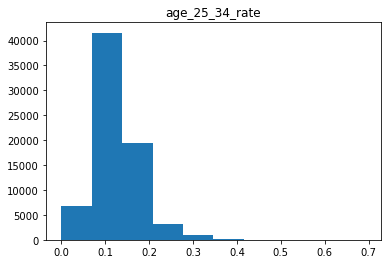

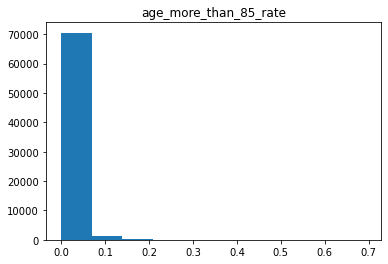

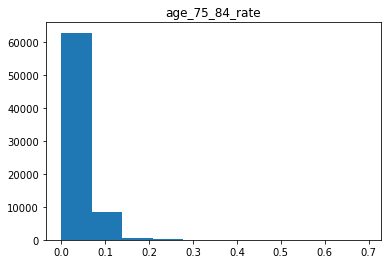

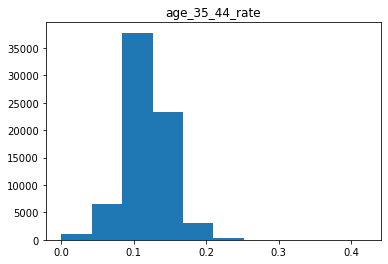

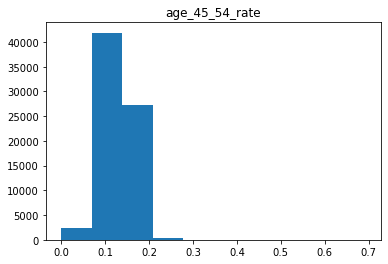

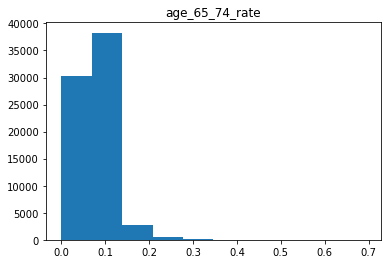

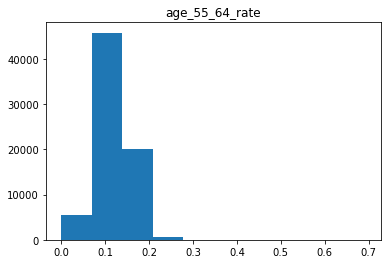

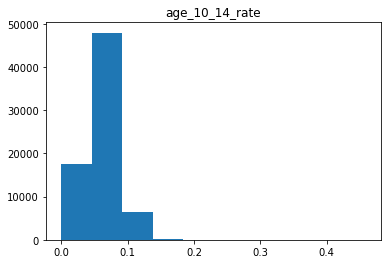

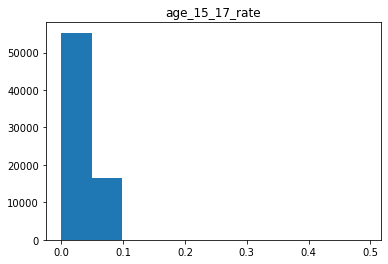

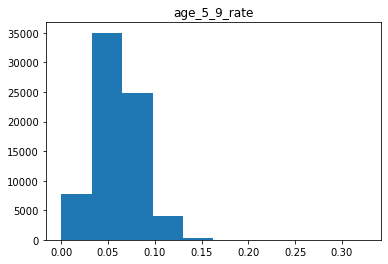

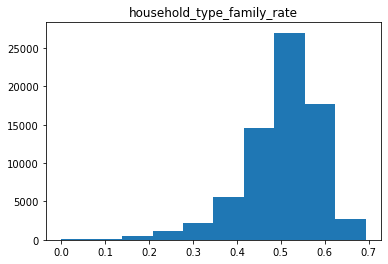

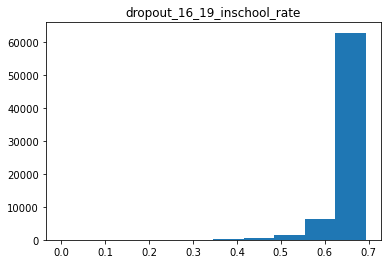

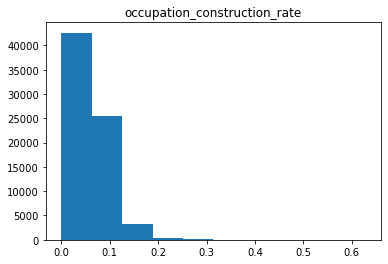

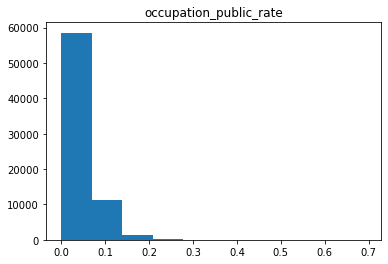

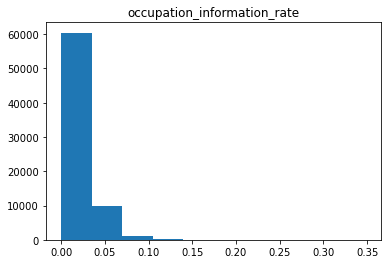

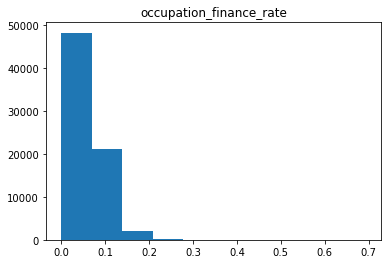

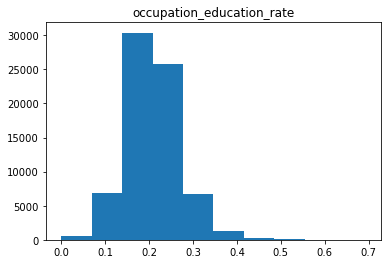

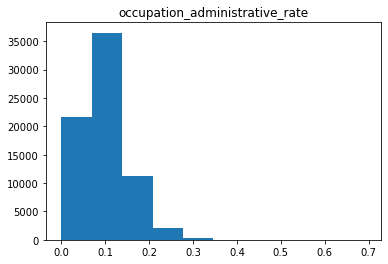

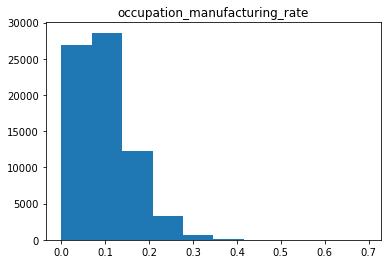

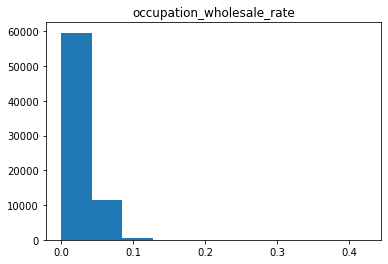

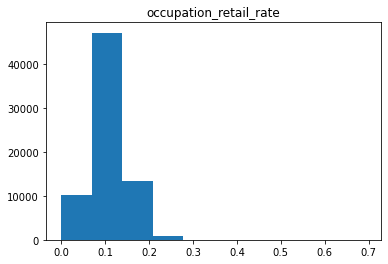

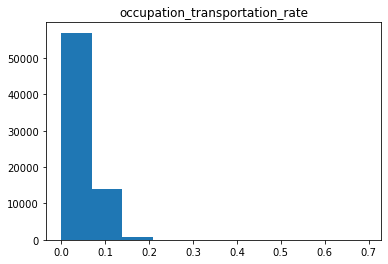

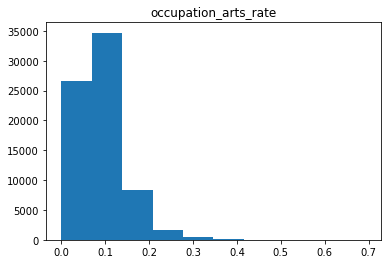

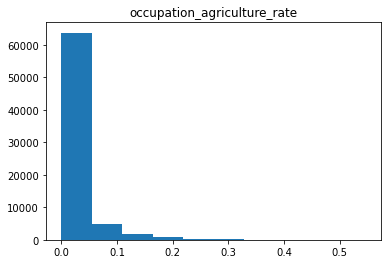

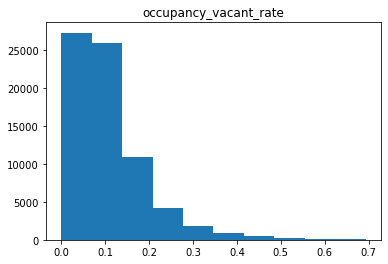

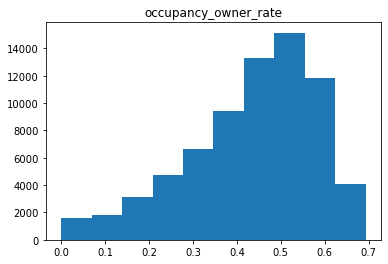

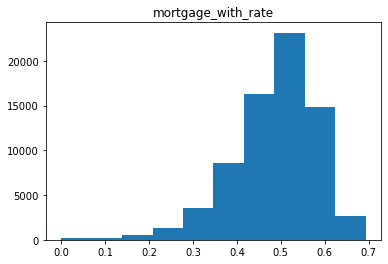

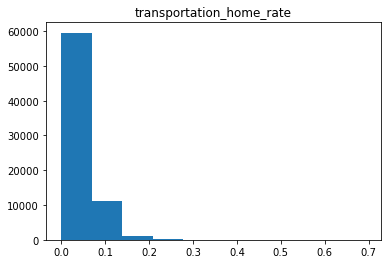

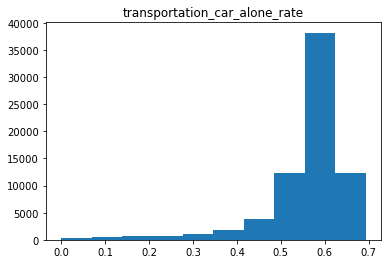

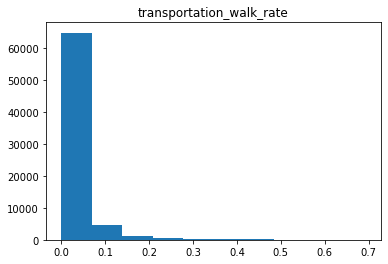

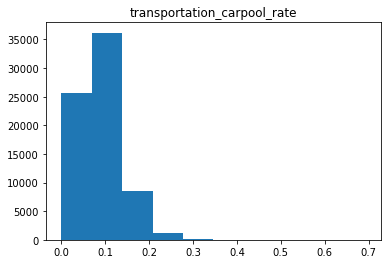

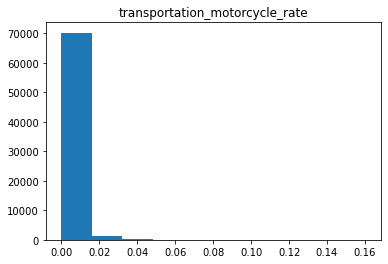

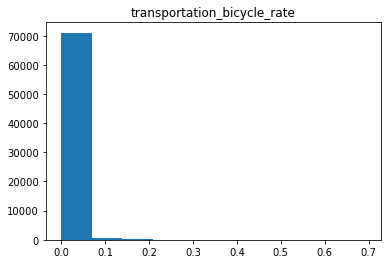

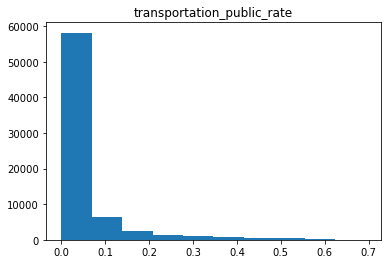

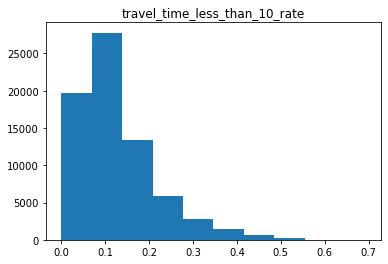

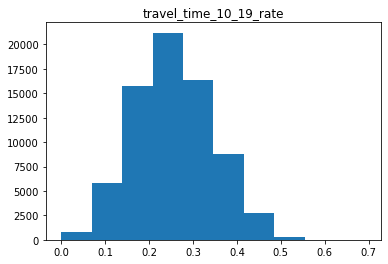

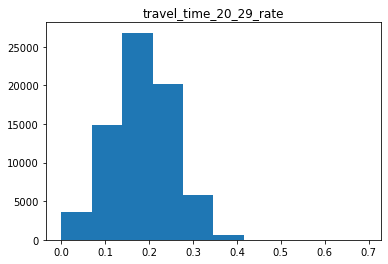

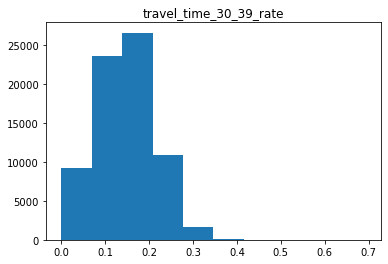

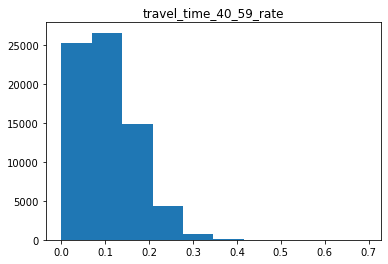

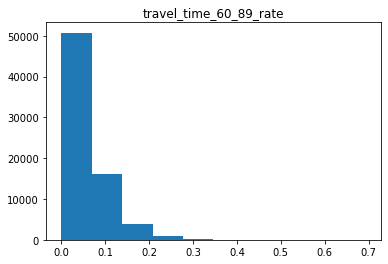

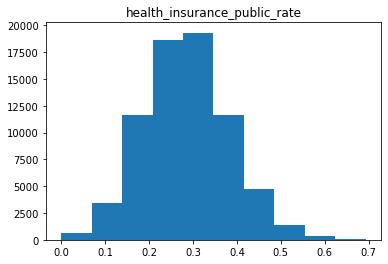

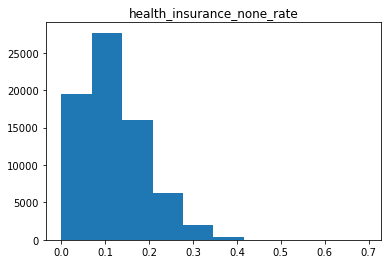

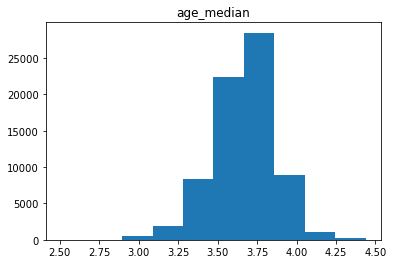

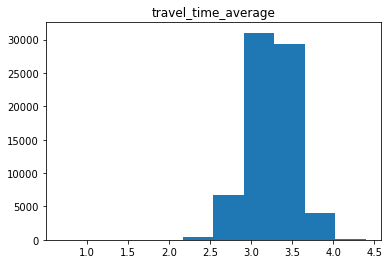

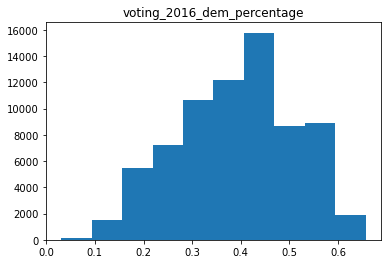

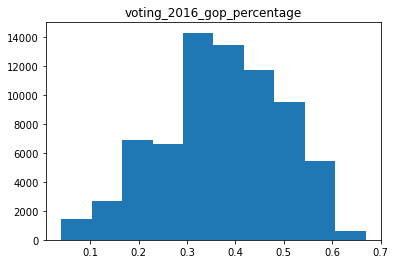

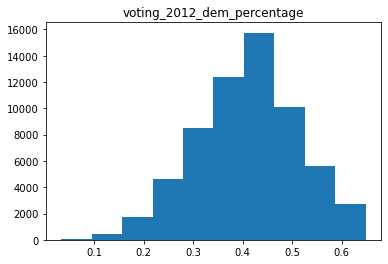

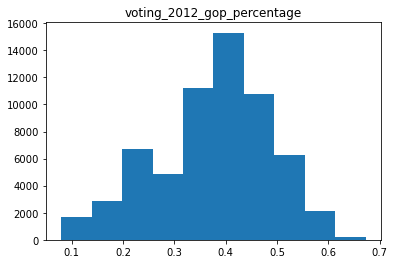

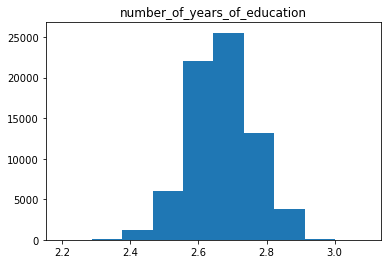

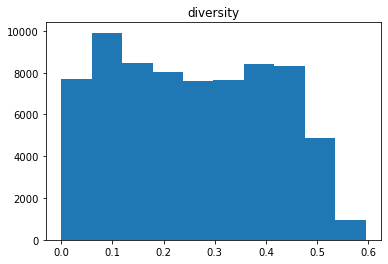

number_of_solar_system_per_household  did not plot


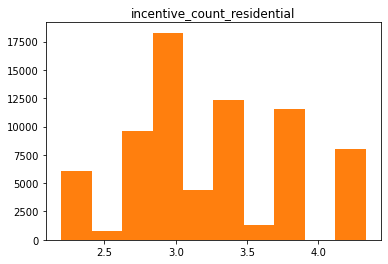

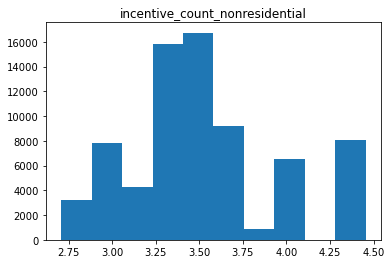

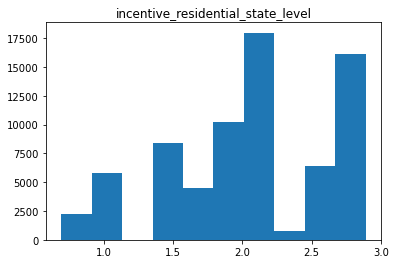

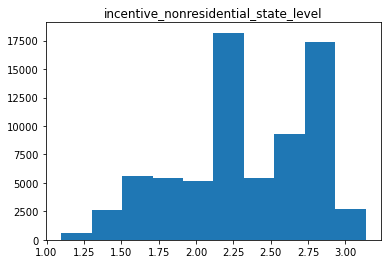

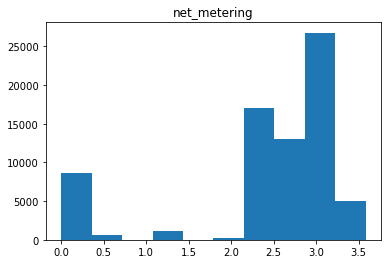

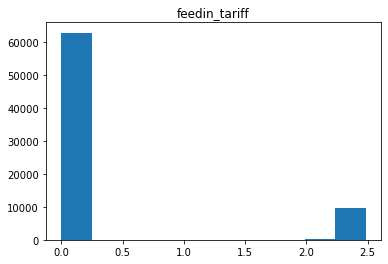

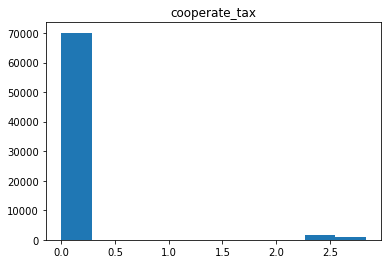

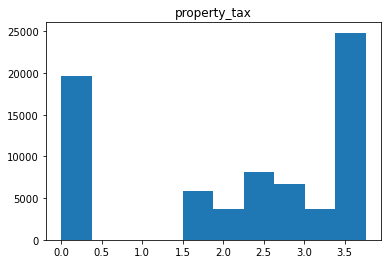

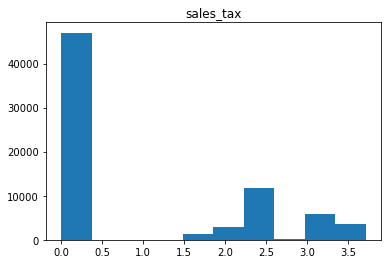

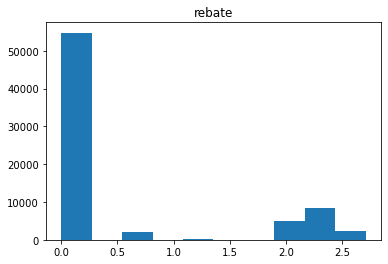

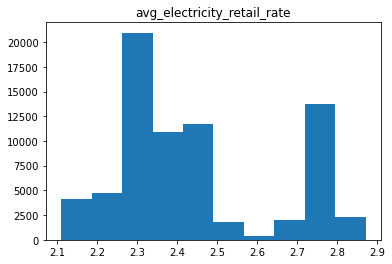

In [26]:
#Investigate distribution of values for numeric columns
for col in list(test.select_dtypes(include=[np.number]).columns.values):
    try:
        plt.title(col)
        plt.hist(test[col].apply(lambda x: np.log(x+1)))
        plt.show()
    except:
        print(col, ' did not plot')

From the distributions above, there do not seem to be any outliers in the distributions.

In [21]:
#Explore the percentage of churners vs. non-churners in the data
df_new['Churn'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: Churn, dtype: float64

There is a higher percentage of non-churners than churners in the dataset, which may skew the model. To correct for this, we will determine the class imbalance and re-sample the data within the respective models later in the code.

In [22]:
#Set seed for reproducability
seed = 111

In [23]:
#Define the binary target variable for classification model
binary_var = 'Churn'

In [24]:
#Separate data into x and y
x = df_new[df_new.columns.difference([binary_var])]
y = df_new[binary_var]

# Model Creation

## Random Forest Model

In [25]:
#Label encode the categorical columns within the x data since categorical variables are not accepted in
#Random Forest models
x_cat = clean.label_encoding(x)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
#Ensure all columns are numeric
x_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Contract          7043 non-null   int64  
 1   Dependents        7043 non-null   int64  
 2   DeviceProtection  7043 non-null   int64  
 3   InternetService   7043 non-null   int64  
 4   MonthlyCharges    7043 non-null   float64
 5   MultipleLines     7043 non-null   int64  
 6   OnlineBackup      7043 non-null   int64  
 7   OnlineSecurity    7043 non-null   int64  
 8   PaperlessBilling  7043 non-null   int64  
 9   Partner           7043 non-null   int64  
 10  PaymentMethod     7043 non-null   int64  
 11  PhoneService      7043 non-null   int64  
 12  SeniorCitizen     7043 non-null   int64  
 13  StreamingMovies   7043 non-null   int64  
 14  StreamingTV       7043 non-null   int64  
 15  TechSupport       7043 non-null   int64  
 16  TotalCharges      7043 non-null   float64


In [27]:
#Split the encoded data into train and test sets
x_cat_train, x_cat_test, y_cat_train, y_cat_test = train_test_split(x_cat, y, stratify=y, 
                                                                    test_size=0.2, random_state=seed)

In [28]:
#Define random_grid for parameter tuning random search
random_grid = {'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
                          'max_features': ['auto', 'sqrt'],
                          'max_depth': [int(x) for x in np.linspace(100, 110, num=2)],
                          'min_samples_split': [2, 5, 10],
                          'min_samples_leaf': [1, 2, 5],
                          'bootstrap': [True, False],
                          'class_weight': ['balanced']}

In [29]:
#Run a random search of Random Forest parameters to find best initial hyper parameters. Use stratified k-fold
#cross-validation in randomsearch
params = parameter_tuning.randomsearch(seed, x_cat, y, random_grid, 'rf')

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  8.0min finished


In [30]:
print(params)

{'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 110, 'class_weight': 'balanced', 'bootstrap': False}


In [31]:
#Define random grid for grid search parameter tuning
random_grid = {'n_estimators': [600, 700],
                          'max_features': ['auto','sqrt'],
                          'max_depth': [110],
                          'min_samples_split': [4, 5, 6],
                          'min_samples_leaf': [5, 6],
                          'bootstrap': [False],
                          'class_weight': ['balanced']}

In [32]:
#Run a more intensive grid search to tune hyper parameters for Random Forest Model.  Use stratified k-fold
#cross-validation in randomsearch
params = parameter_tuning.gridsearch(seed, x_cat, y, random_grid, 'rf')

Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  1.1min finished


In [33]:
print(params)

{'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 110, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 700}


In [34]:
#Run the preliminary Random Forest Model
rf_mod = models.rf_model(x_cat_train, y_cat_train, seed, **params)

In [35]:
#Explore feature importance
rf_mod_imp = pd.DataFrame({'Gini-importance': rf_mod.feature_importances_, 'col': x_cat_train.columns})
rf_mod_imp = rf_mod_imp.sort_values(['Gini-importance', 'col'], ascending=False)
#Keep features with a Gini-importance >= 0.01
rf_mod_imp = rf_mod_imp[rf_mod_imp['Gini-importance'] >= 0.01]
print(rf_mod_imp)

    Gini-importance               col
0          0.199220          Contract
18         0.148623            tenure
16         0.130092      TotalCharges
4          0.117698    MonthlyCharges
7          0.088758    OnlineSecurity
15         0.076163       TechSupport
3          0.050806   InternetService
10         0.033657     PaymentMethod
6          0.029734      OnlineBackup
2          0.024414  DeviceProtection
8          0.019808  PaperlessBilling
17         0.014583            gender
9          0.011598           Partner
13         0.011162   StreamingMovies
5          0.011026     MultipleLines


In [36]:
#Keep top importance features in the x data
x_rf_imp = x_cat[rf_mod_imp['col']]
x_train_rf_imp = x_cat_train[rf_mod_imp['col']]
x_test_rf_imp = x_cat_test[rf_mod_imp['col']]

In [37]:
#Run Random Forest model with only important features
rf_mod = models.rf_model(x_train_rf_imp, y_cat_train, seed, **params)

In [38]:
#Use Random Forest model to make predictions on train and test sets
y_pred_train_rf, y_pred_test_rf = evaluation.predictions(rf_mod, x_train_rf_imp, x_test_rf_imp)

In [39]:
#Examine model performance metrics
rf_results = evaluation.results(y_cat_train, y_cat_test, y_pred_train_rf, y_pred_test_rf)

In [40]:
print(rf_results)

               Test     Train
Metrics                      
AUC        0.745807  0.895745
Accuracy   0.765791  0.872559
F1         0.614486  0.797404
Recall     0.703209  0.945151
Precision  0.545643  0.689605


Random Forest seems to be slightly overfitting. Experiment with XGBoost model to see if there is better performance.

## XGBoost Model

In [41]:
#Define scale_pos weight term to compensate for class imbalance in XGBoost model
scale_pos = y_cat_train.value_counts()[0]/y_cat_train.value_counts()[1]

In [42]:
#Create random grid for random search parameter tuning
random_grid = {'min_child_weight': [1, 5, 10],
                          'gamma': [0.5, 1, 1.5, 2, 5],
                          'subsample': [0.6, 0.8, 1.0],
                          'colsample_bytree': [0.6, 0.8, 1.0],
                          'max_depth': [3, 4, 5],
                          'scale_pos_weight': [scale_pos]}

In [43]:
#Run a random search of XGboost parameters to find best initial hyper parameters
params = parameter_tuning.randomsearch(seed, x_cat, y, random_grid, 'xgboost')

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   53.9s finished


In [44]:
print(params)

{'subsample': 1.0, 'scale_pos_weight': 2.768561872909699, 'min_child_weight': 1, 'max_depth': 3, 'gamma': 0.5, 'colsample_bytree': 0.6}


In [45]:
#Define random grid for grid search parameter tuning
random_grid = {'min_child_weight': [1, 2],
                          'gamma': [0.5, 1, 1.5],
                          'subsample': [0.9, 1],
                          'colsample_bytree': [0.5, 0.6, 0.7],
                          'max_depth': [3, 4, 5],
                          'scale_pos_weight': [scale_pos]}

In [46]:
#Run a more intensive grid search to tune hyper parameters for XGBoost Model.  Use stratified k-fold
#cross-validation in randomsearch
params = parameter_tuning.gridsearch(seed, x_cat, y, random_grid, 'xgboost')

Fitting 4 folds for each of 108 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:   50.6s finished


In [47]:
print(params)

{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'scale_pos_weight': 2.768561872909699, 'subsample': 1}


In [48]:
#Run the preliminary XGboost Model
xgb_mod = models.xgboost_model(x_cat_train, y_cat_train, seed, **params)

In [49]:
print(params)

{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'scale_pos_weight': 2.768561872909699, 'subsample': 1}


In [50]:
#Explore feature importance
xgb_mod_imp = pd.DataFrame({'Gini-importance': xgb_mod.feature_importances_, 'col': x_cat_train.columns})
xgb_mod_imp = xgb_mod_imp.sort_values(['Gini-importance', 'col'], ascending=False)
#Keep features with a Gini-importance >= 0.01
xgb_mod_imp = xgb_mod_imp[xgb_mod_imp['Gini-importance'] >= 0.01]
print(xgb_mod_imp)

    Gini-importance               col
15         0.317443       TechSupport
0          0.185561          Contract
7          0.181616    OnlineSecurity
3          0.070548   InternetService
18         0.038554            tenure
16         0.026629      TotalCharges
8          0.022690  PaperlessBilling
4          0.021965    MonthlyCharges
6          0.020378      OnlineBackup
10         0.017559     PaymentMethod
2          0.016283  DeviceProtection
13         0.015364   StreamingMovies
9          0.013162           Partner
1          0.011674        Dependents
5          0.010410     MultipleLines
12         0.010156     SeniorCitizen


In [51]:
#Keep top importance features in the x data
x_xgb_imp = x_cat[xgb_mod_imp['col']]
x_train_xgb_imp = x_cat_train[xgb_mod_imp['col']]
x_test_xgb_imp = x_cat_test[xgb_mod_imp['col']]

In [52]:
#Run XGboost Model
xgb_mod = models.xgboost_model(x_train_xgb_imp, y_cat_train, seed, **params)

In [53]:
#Make predictions on train and test sets
y_pred_train_xgb, y_pred_test_xgb = evaluation.predictions(xgb_mod, x_train_xgb_imp, x_test_xgb_imp)

In [54]:
#Examine model metric esults
xgb_results = evaluation.results(y_cat_train, y_cat_test, y_pred_train_xgb, y_pred_test_xgb)
print(xgb_results)

               Test     Train
Metrics                      
AUC        0.758749  0.788635
Accuracy   0.745919  0.768548
F1         0.621564  0.655937
Recall     0.786096  0.831438
Precision  0.513986  0.541612


## CatBoost Model

In [55]:
#Split data into test, train, and validation sets
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.15, random_state=seed)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.15, random_state=seed)

In [56]:
#Define scale_pos weight term to compensate for class imbalance in CatBoost model
scale_pos = y_train.value_counts()[0]/y_train.value_counts()[1]

In [57]:
#Create random grid for random search parameter tuning
random_grid = {'learning_rate': [0.03, 0.1],
                          'l2_leaf_reg': [1, 3, 5, 7, 9],
                          'depth': [4, 6, 10],
                          'scale_pos_weight': [scale_pos]}

In [58]:
#Run a random search of XGboost parameters to find best initial hyper parameters
params = parameter_tuning.randomsearch(seed, x_cat, y, random_grid, 'catboost')

Fitting 4 folds for each of 30 candidates, totalling 120 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 30 is smaller than n_iter=100. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  7.2min finished


0:	learn: 0.6814071	total: 61ms	remaining: 1m
1:	learn: 0.6701767	total: 65ms	remaining: 32.4s
2:	learn: 0.6591148	total: 68.3ms	remaining: 22.7s
3:	learn: 0.6496351	total: 71.2ms	remaining: 17.7s
4:	learn: 0.6408272	total: 73.6ms	remaining: 14.6s
5:	learn: 0.6312974	total: 76.1ms	remaining: 12.6s
6:	learn: 0.6240217	total: 78.5ms	remaining: 11.1s
7:	learn: 0.6163803	total: 80.9ms	remaining: 10s
8:	learn: 0.6094435	total: 83.2ms	remaining: 9.16s
9:	learn: 0.6034422	total: 85.5ms	remaining: 8.46s
10:	learn: 0.5976467	total: 87.9ms	remaining: 7.9s
11:	learn: 0.5911405	total: 90.3ms	remaining: 7.43s
12:	learn: 0.5862898	total: 92.7ms	remaining: 7.04s
13:	learn: 0.5814133	total: 95.1ms	remaining: 6.7s
14:	learn: 0.5757931	total: 97.4ms	remaining: 6.4s
15:	learn: 0.5712449	total: 99.8ms	remaining: 6.14s
16:	learn: 0.5673924	total: 102ms	remaining: 5.91s
17:	learn: 0.5640269	total: 105ms	remaining: 5.71s
18:	learn: 0.5594948	total: 107ms	remaining: 5.53s
19:	learn: 0.5556939	total: 110ms	rem

187:	learn: 0.4648562	total: 637ms	remaining: 2.75s
188:	learn: 0.4647846	total: 641ms	remaining: 2.75s
189:	learn: 0.4647056	total: 645ms	remaining: 2.75s
190:	learn: 0.4645878	total: 649ms	remaining: 2.75s
191:	learn: 0.4644843	total: 653ms	remaining: 2.75s
192:	learn: 0.4643974	total: 657ms	remaining: 2.75s
193:	learn: 0.4643009	total: 661ms	remaining: 2.75s
194:	learn: 0.4642307	total: 664ms	remaining: 2.74s
195:	learn: 0.4641874	total: 666ms	remaining: 2.73s
196:	learn: 0.4640821	total: 669ms	remaining: 2.73s
197:	learn: 0.4640100	total: 671ms	remaining: 2.72s
198:	learn: 0.4639416	total: 673ms	remaining: 2.71s
199:	learn: 0.4638786	total: 676ms	remaining: 2.7s
200:	learn: 0.4637817	total: 679ms	remaining: 2.7s
201:	learn: 0.4636764	total: 681ms	remaining: 2.69s
202:	learn: 0.4635442	total: 684ms	remaining: 2.68s
203:	learn: 0.4633827	total: 686ms	remaining: 2.68s
204:	learn: 0.4632693	total: 689ms	remaining: 2.67s
205:	learn: 0.4632262	total: 691ms	remaining: 2.66s
206:	learn: 0.

401:	learn: 0.4467634	total: 1.21s	remaining: 1.81s
402:	learn: 0.4466678	total: 1.22s	remaining: 1.8s
403:	learn: 0.4465587	total: 1.22s	remaining: 1.8s
404:	learn: 0.4464791	total: 1.23s	remaining: 1.8s
405:	learn: 0.4464157	total: 1.23s	remaining: 1.8s
406:	learn: 0.4462947	total: 1.23s	remaining: 1.8s
407:	learn: 0.4462078	total: 1.24s	remaining: 1.79s
408:	learn: 0.4461540	total: 1.24s	remaining: 1.79s
409:	learn: 0.4460451	total: 1.24s	remaining: 1.79s
410:	learn: 0.4459576	total: 1.24s	remaining: 1.78s
411:	learn: 0.4458547	total: 1.25s	remaining: 1.78s
412:	learn: 0.4457664	total: 1.25s	remaining: 1.78s
413:	learn: 0.4456763	total: 1.25s	remaining: 1.77s
414:	learn: 0.4456256	total: 1.26s	remaining: 1.77s
415:	learn: 0.4455285	total: 1.26s	remaining: 1.77s
416:	learn: 0.4454521	total: 1.26s	remaining: 1.76s
417:	learn: 0.4453971	total: 1.27s	remaining: 1.76s
418:	learn: 0.4452890	total: 1.27s	remaining: 1.76s
419:	learn: 0.4451995	total: 1.27s	remaining: 1.76s
420:	learn: 0.445

608:	learn: 0.4309447	total: 1.79s	remaining: 1.15s
609:	learn: 0.4308924	total: 1.79s	remaining: 1.15s
610:	learn: 0.4308162	total: 1.79s	remaining: 1.14s
611:	learn: 0.4307678	total: 1.8s	remaining: 1.14s
612:	learn: 0.4307330	total: 1.8s	remaining: 1.14s
613:	learn: 0.4306183	total: 1.81s	remaining: 1.14s
614:	learn: 0.4305263	total: 1.81s	remaining: 1.13s
615:	learn: 0.4304377	total: 1.81s	remaining: 1.13s
616:	learn: 0.4303615	total: 1.82s	remaining: 1.13s
617:	learn: 0.4302674	total: 1.82s	remaining: 1.12s
618:	learn: 0.4302096	total: 1.82s	remaining: 1.12s
619:	learn: 0.4300709	total: 1.82s	remaining: 1.12s
620:	learn: 0.4300183	total: 1.83s	remaining: 1.11s
621:	learn: 0.4299638	total: 1.83s	remaining: 1.11s
622:	learn: 0.4299124	total: 1.83s	remaining: 1.11s
623:	learn: 0.4297802	total: 1.83s	remaining: 1.1s
624:	learn: 0.4297256	total: 1.84s	remaining: 1.1s
625:	learn: 0.4296723	total: 1.84s	remaining: 1.1s
626:	learn: 0.4296247	total: 1.84s	remaining: 1.1s
627:	learn: 0.4295

818:	learn: 0.4179895	total: 2.37s	remaining: 523ms
819:	learn: 0.4179421	total: 2.37s	remaining: 520ms
820:	learn: 0.4178970	total: 2.37s	remaining: 518ms
821:	learn: 0.4178213	total: 2.38s	remaining: 515ms
822:	learn: 0.4177541	total: 2.38s	remaining: 512ms
823:	learn: 0.4177224	total: 2.38s	remaining: 510ms
824:	learn: 0.4176505	total: 2.39s	remaining: 507ms
825:	learn: 0.4176327	total: 2.39s	remaining: 504ms
826:	learn: 0.4175623	total: 2.39s	remaining: 501ms
827:	learn: 0.4174737	total: 2.4s	remaining: 498ms
828:	learn: 0.4174071	total: 2.4s	remaining: 495ms
829:	learn: 0.4173545	total: 2.4s	remaining: 492ms
830:	learn: 0.4173263	total: 2.41s	remaining: 490ms
831:	learn: 0.4173087	total: 2.41s	remaining: 487ms
832:	learn: 0.4172657	total: 2.42s	remaining: 484ms
833:	learn: 0.4171755	total: 2.42s	remaining: 482ms
834:	learn: 0.4171313	total: 2.42s	remaining: 479ms
835:	learn: 0.4170852	total: 2.43s	remaining: 476ms
836:	learn: 0.4170354	total: 2.43s	remaining: 473ms
837:	learn: 0.4

In [59]:
print(params)

{'scale_pos_weight': 2.766099185788305, 'learning_rate': 0.03, 'l2_leaf_reg': 9, 'depth': 4}


In [60]:
#Create random grid for grid search parameter tuning
random_grid = {'learning_rate': [0.03, 0.05],
                          'l2_leaf_reg': [8, 9, 10],
                          'depth': [4, 5, 6],
                          'scale_pos_weight': [scale_pos]}

In [61]:
#Run a more intensive grid search to tune hyper parameters for CatBoost Model.  Use stratified k-fold
#cross-validation in randomsearch
params = parameter_tuning.gridsearch(seed, x_cat, y, random_grid, 'catboost')

Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  3.3min finished


0:	learn: 0.6806977	total: 2.5ms	remaining: 2.5s
1:	learn: 0.6701094	total: 5.16ms	remaining: 2.58s
2:	learn: 0.6597794	total: 7.53ms	remaining: 2.5s
3:	learn: 0.6501463	total: 10ms	remaining: 2.49s
4:	learn: 0.6418654	total: 12.6ms	remaining: 2.5s
5:	learn: 0.6330493	total: 15.1ms	remaining: 2.51s
6:	learn: 0.6262935	total: 17.6ms	remaining: 2.49s
7:	learn: 0.6179110	total: 20.8ms	remaining: 2.58s
8:	learn: 0.6105553	total: 24.6ms	remaining: 2.71s
9:	learn: 0.6046676	total: 29ms	remaining: 2.88s
10:	learn: 0.5982424	total: 31.5ms	remaining: 2.84s
11:	learn: 0.5921107	total: 34.4ms	remaining: 2.83s
12:	learn: 0.5869730	total: 36.9ms	remaining: 2.8s
13:	learn: 0.5821681	total: 39.1ms	remaining: 2.75s
14:	learn: 0.5766915	total: 41.6ms	remaining: 2.73s
15:	learn: 0.5719472	total: 44.1ms	remaining: 2.71s
16:	learn: 0.5672266	total: 46.6ms	remaining: 2.69s
17:	learn: 0.5639064	total: 49.1ms	remaining: 2.68s
18:	learn: 0.5594906	total: 51.5ms	remaining: 2.66s
19:	learn: 0.5550311	total: 54m

197:	learn: 0.4649693	total: 579ms	remaining: 2.35s
198:	learn: 0.4649007	total: 583ms	remaining: 2.35s
199:	learn: 0.4647954	total: 586ms	remaining: 2.35s
200:	learn: 0.4646608	total: 593ms	remaining: 2.35s
201:	learn: 0.4645189	total: 598ms	remaining: 2.36s
202:	learn: 0.4644123	total: 602ms	remaining: 2.36s
203:	learn: 0.4643307	total: 604ms	remaining: 2.36s
204:	learn: 0.4642331	total: 607ms	remaining: 2.35s
205:	learn: 0.4641889	total: 609ms	remaining: 2.35s
206:	learn: 0.4641076	total: 611ms	remaining: 2.34s
207:	learn: 0.4640003	total: 614ms	remaining: 2.34s
208:	learn: 0.4639329	total: 617ms	remaining: 2.33s
209:	learn: 0.4637892	total: 620ms	remaining: 2.33s
210:	learn: 0.4637055	total: 622ms	remaining: 2.33s
211:	learn: 0.4635601	total: 624ms	remaining: 2.32s
212:	learn: 0.4634307	total: 627ms	remaining: 2.31s
213:	learn: 0.4633132	total: 629ms	remaining: 2.31s
214:	learn: 0.4632826	total: 631ms	remaining: 2.31s
215:	learn: 0.4631611	total: 636ms	remaining: 2.31s
216:	learn: 

411:	learn: 0.4456972	total: 1.15s	remaining: 1.65s
412:	learn: 0.4456066	total: 1.16s	remaining: 1.65s
413:	learn: 0.4455003	total: 1.16s	remaining: 1.64s
414:	learn: 0.4454315	total: 1.17s	remaining: 1.64s
415:	learn: 0.4453417	total: 1.17s	remaining: 1.64s
416:	learn: 0.4452693	total: 1.17s	remaining: 1.64s
417:	learn: 0.4452134	total: 1.18s	remaining: 1.64s
418:	learn: 0.4451138	total: 1.18s	remaining: 1.64s
419:	learn: 0.4450820	total: 1.18s	remaining: 1.63s
420:	learn: 0.4449814	total: 1.19s	remaining: 1.63s
421:	learn: 0.4449120	total: 1.19s	remaining: 1.63s
422:	learn: 0.4448272	total: 1.19s	remaining: 1.63s
423:	learn: 0.4447761	total: 1.19s	remaining: 1.62s
424:	learn: 0.4447096	total: 1.2s	remaining: 1.62s
425:	learn: 0.4446274	total: 1.2s	remaining: 1.62s
426:	learn: 0.4444950	total: 1.2s	remaining: 1.61s
427:	learn: 0.4444217	total: 1.21s	remaining: 1.61s
428:	learn: 0.4442963	total: 1.21s	remaining: 1.61s
429:	learn: 0.4441967	total: 1.21s	remaining: 1.6s
430:	learn: 0.44

620:	learn: 0.4300928	total: 1.73s	remaining: 1.05s
621:	learn: 0.4300425	total: 1.73s	remaining: 1.05s
622:	learn: 0.4299328	total: 1.74s	remaining: 1.05s
623:	learn: 0.4298867	total: 1.74s	remaining: 1.05s
624:	learn: 0.4298157	total: 1.75s	remaining: 1.05s
625:	learn: 0.4297224	total: 1.75s	remaining: 1.05s
626:	learn: 0.4296551	total: 1.75s	remaining: 1.04s
627:	learn: 0.4296334	total: 1.76s	remaining: 1.04s
628:	learn: 0.4295822	total: 1.76s	remaining: 1.04s
629:	learn: 0.4295519	total: 1.76s	remaining: 1.03s
630:	learn: 0.4294946	total: 1.76s	remaining: 1.03s
631:	learn: 0.4293784	total: 1.77s	remaining: 1.03s
632:	learn: 0.4292906	total: 1.77s	remaining: 1.03s
633:	learn: 0.4292266	total: 1.77s	remaining: 1.02s
634:	learn: 0.4291242	total: 1.78s	remaining: 1.02s
635:	learn: 0.4290343	total: 1.78s	remaining: 1.02s
636:	learn: 0.4289470	total: 1.78s	remaining: 1.01s
637:	learn: 0.4288987	total: 1.78s	remaining: 1.01s
638:	learn: 0.4288074	total: 1.79s	remaining: 1.01s
639:	learn: 

831:	learn: 0.4171914	total: 2.31s	remaining: 466ms
832:	learn: 0.4171507	total: 2.31s	remaining: 464ms
833:	learn: 0.4171012	total: 2.32s	remaining: 461ms
834:	learn: 0.4170258	total: 2.32s	remaining: 459ms
835:	learn: 0.4169649	total: 2.33s	remaining: 456ms
836:	learn: 0.4169524	total: 2.33s	remaining: 453ms
837:	learn: 0.4169349	total: 2.33s	remaining: 451ms
838:	learn: 0.4168839	total: 2.33s	remaining: 448ms
839:	learn: 0.4168295	total: 2.34s	remaining: 445ms
840:	learn: 0.4167562	total: 2.34s	remaining: 442ms
841:	learn: 0.4167221	total: 2.34s	remaining: 439ms
842:	learn: 0.4166830	total: 2.34s	remaining: 437ms
843:	learn: 0.4165956	total: 2.35s	remaining: 434ms
844:	learn: 0.4165490	total: 2.35s	remaining: 431ms
845:	learn: 0.4164824	total: 2.35s	remaining: 428ms
846:	learn: 0.4164125	total: 2.35s	remaining: 425ms
847:	learn: 0.4163509	total: 2.36s	remaining: 423ms
848:	learn: 0.4162755	total: 2.36s	remaining: 420ms
849:	learn: 0.4162337	total: 2.36s	remaining: 417ms
850:	learn: 

In [62]:
print(params)

{'depth': 4, 'l2_leaf_reg': 9, 'learning_rate': 0.03, 'scale_pos_weight': 2.766099185788305}


In [63]:
#Run preliminary catboost model
catboost_mod = models.catboost_model(x_train, x_val, y_train, y_val, seed, use_best_mod=True, **params)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7883050	test: 0.7647059	best: 0.7647059 (0)	total: 9.8ms	remaining: 9.79s
1:	learn: 0.8423390	test: 0.8361345	best: 0.8361345 (1)	total: 15.4ms	remaining: 7.7s
2:	learn: 0.8430792	test: 0.8487395	best: 0.8487395 (2)	total: 20.4ms	remaining: 6.79s
3:	learn: 0.8290155	test: 0.8445378	best: 0.8487395 (2)	total: 29.4ms	remaining: 7.33s
4:	learn: 0.8475204	test: 0.8487395	best: 0.8487395 (2)	total: 34.1ms	remaining: 6.79s
5:	learn: 0.8586232	test: 0.8571429	best: 0.8571429 (5)	total: 39.3ms	remaining: 6.5s
6:	learn: 0.8549223	test: 0.8529412	best: 0.8571429 (5)	total: 43.6ms	remaining: 6.19s
7:	learn: 0.8519615	test: 0.8529412	best: 0.8571429 (5)	total: 48.7ms	remaining: 6.04s
8:	learn: 0.8564027	test: 0.8487395	best: 0.8571429 (5)	total: 54.5ms	remaining: 6s
9:	learn: 0.8586232	test: 0.8571429	best: 0.8571429 (5)	total: 60.3ms	remaining: 5.97s
10:	learn: 0.8630644	test: 0.8571429	best: 0.8571429 (5)	total: 65.5ms	remaining: 5.89s
11:	learn: 0.8667654	test: 0.8613445	best: 0.861

101:	learn: 0.8312361	test: 0.8445378	best: 0.8613445 (11)	total: 462ms	remaining: 4.07s
102:	learn: 0.8334567	test: 0.8445378	best: 0.8613445 (11)	total: 466ms	remaining: 4.06s
103:	learn: 0.8319763	test: 0.8445378	best: 0.8613445 (11)	total: 470ms	remaining: 4.04s
104:	learn: 0.8327165	test: 0.8445378	best: 0.8613445 (11)	total: 473ms	remaining: 4.03s
105:	learn: 0.8327165	test: 0.8403361	best: 0.8613445 (11)	total: 477ms	remaining: 4.03s
106:	learn: 0.8319763	test: 0.8445378	best: 0.8613445 (11)	total: 483ms	remaining: 4.03s
107:	learn: 0.8334567	test: 0.8403361	best: 0.8613445 (11)	total: 488ms	remaining: 4.03s
108:	learn: 0.8327165	test: 0.8361345	best: 0.8613445 (11)	total: 494ms	remaining: 4.04s
109:	learn: 0.8327165	test: 0.8361345	best: 0.8613445 (11)	total: 500ms	remaining: 4.05s
110:	learn: 0.8334567	test: 0.8361345	best: 0.8613445 (11)	total: 504ms	remaining: 4.04s
111:	learn: 0.8341969	test: 0.8361345	best: 0.8613445 (11)	total: 508ms	remaining: 4.03s
112:	learn: 0.8327165

198:	learn: 0.8275352	test: 0.8319328	best: 0.8613445 (11)	total: 778ms	remaining: 3.13s
199:	learn: 0.8282754	test: 0.8319328	best: 0.8613445 (11)	total: 782ms	remaining: 3.13s
200:	learn: 0.8282754	test: 0.8319328	best: 0.8613445 (11)	total: 786ms	remaining: 3.12s
201:	learn: 0.8282754	test: 0.8319328	best: 0.8613445 (11)	total: 790ms	remaining: 3.12s
202:	learn: 0.8282754	test: 0.8319328	best: 0.8613445 (11)	total: 795ms	remaining: 3.12s
203:	learn: 0.8282754	test: 0.8319328	best: 0.8613445 (11)	total: 799ms	remaining: 3.12s
204:	learn: 0.8282754	test: 0.8361345	best: 0.8613445 (11)	total: 804ms	remaining: 3.12s
205:	learn: 0.8275352	test: 0.8361345	best: 0.8613445 (11)	total: 809ms	remaining: 3.12s
206:	learn: 0.8275352	test: 0.8361345	best: 0.8613445 (11)	total: 813ms	remaining: 3.11s
207:	learn: 0.8275352	test: 0.8361345	best: 0.8613445 (11)	total: 815ms	remaining: 3.1s
208:	learn: 0.8275352	test: 0.8361345	best: 0.8613445 (11)	total: 818ms	remaining: 3.1s
209:	learn: 0.8282754	t

312:	learn: 0.8282754	test: 0.8319328	best: 0.8613445 (11)	total: 1.12s	remaining: 2.46s
313:	learn: 0.8282754	test: 0.8319328	best: 0.8613445 (11)	total: 1.12s	remaining: 2.46s
314:	learn: 0.8282754	test: 0.8319328	best: 0.8613445 (11)	total: 1.13s	remaining: 2.45s
315:	learn: 0.8282754	test: 0.8319328	best: 0.8613445 (11)	total: 1.13s	remaining: 2.45s
316:	learn: 0.8290155	test: 0.8319328	best: 0.8613445 (11)	total: 1.14s	remaining: 2.45s
317:	learn: 0.8282754	test: 0.8319328	best: 0.8613445 (11)	total: 1.14s	remaining: 2.45s
318:	learn: 0.8290155	test: 0.8319328	best: 0.8613445 (11)	total: 1.15s	remaining: 2.44s
319:	learn: 0.8290155	test: 0.8319328	best: 0.8613445 (11)	total: 1.15s	remaining: 2.44s
320:	learn: 0.8297557	test: 0.8319328	best: 0.8613445 (11)	total: 1.15s	remaining: 2.43s
321:	learn: 0.8297557	test: 0.8319328	best: 0.8613445 (11)	total: 1.15s	remaining: 2.43s
322:	learn: 0.8304959	test: 0.8319328	best: 0.8613445 (11)	total: 1.16s	remaining: 2.42s
323:	learn: 0.8297557

437:	learn: 0.8415988	test: 0.8277311	best: 0.8613445 (11)	total: 1.5s	remaining: 1.92s
438:	learn: 0.8415988	test: 0.8277311	best: 0.8613445 (11)	total: 1.5s	remaining: 1.92s
439:	learn: 0.8415988	test: 0.8277311	best: 0.8613445 (11)	total: 1.51s	remaining: 1.92s
440:	learn: 0.8415988	test: 0.8277311	best: 0.8613445 (11)	total: 1.51s	remaining: 1.92s
441:	learn: 0.8430792	test: 0.8277311	best: 0.8613445 (11)	total: 1.51s	remaining: 1.91s
442:	learn: 0.8430792	test: 0.8277311	best: 0.8613445 (11)	total: 1.52s	remaining: 1.91s
443:	learn: 0.8430792	test: 0.8277311	best: 0.8613445 (11)	total: 1.52s	remaining: 1.9s
444:	learn: 0.8430792	test: 0.8277311	best: 0.8613445 (11)	total: 1.52s	remaining: 1.9s
445:	learn: 0.8430792	test: 0.8277311	best: 0.8613445 (11)	total: 1.52s	remaining: 1.89s
446:	learn: 0.8430792	test: 0.8277311	best: 0.8613445 (11)	total: 1.53s	remaining: 1.89s
447:	learn: 0.8430792	test: 0.8277311	best: 0.8613445 (11)	total: 1.53s	remaining: 1.88s
448:	learn: 0.8430792	tes

539:	learn: 0.8519615	test: 0.8193277	best: 0.8613445 (11)	total: 1.77s	remaining: 1.51s
540:	learn: 0.8519615	test: 0.8151261	best: 0.8613445 (11)	total: 1.78s	remaining: 1.51s
541:	learn: 0.8519615	test: 0.8151261	best: 0.8613445 (11)	total: 1.78s	remaining: 1.5s
542:	learn: 0.8519615	test: 0.8235294	best: 0.8613445 (11)	total: 1.79s	remaining: 1.5s
543:	learn: 0.8519615	test: 0.8235294	best: 0.8613445 (11)	total: 1.79s	remaining: 1.5s
544:	learn: 0.8519615	test: 0.8235294	best: 0.8613445 (11)	total: 1.79s	remaining: 1.5s
545:	learn: 0.8519615	test: 0.8193277	best: 0.8613445 (11)	total: 1.8s	remaining: 1.49s
546:	learn: 0.8519615	test: 0.8151261	best: 0.8613445 (11)	total: 1.8s	remaining: 1.49s
547:	learn: 0.8519615	test: 0.8151261	best: 0.8613445 (11)	total: 1.8s	remaining: 1.49s
548:	learn: 0.8519615	test: 0.8151261	best: 0.8613445 (11)	total: 1.8s	remaining: 1.48s
549:	learn: 0.8519615	test: 0.8151261	best: 0.8613445 (11)	total: 1.81s	remaining: 1.48s
550:	learn: 0.8519615	test: 0

636:	learn: 0.8556625	test: 0.8025210	best: 0.8613445 (11)	total: 2.07s	remaining: 1.18s
637:	learn: 0.8556625	test: 0.8025210	best: 0.8613445 (11)	total: 2.07s	remaining: 1.18s
638:	learn: 0.8556625	test: 0.8025210	best: 0.8613445 (11)	total: 2.08s	remaining: 1.17s
639:	learn: 0.8556625	test: 0.8025210	best: 0.8613445 (11)	total: 2.08s	remaining: 1.17s
640:	learn: 0.8556625	test: 0.8025210	best: 0.8613445 (11)	total: 2.08s	remaining: 1.17s
641:	learn: 0.8556625	test: 0.8025210	best: 0.8613445 (11)	total: 2.09s	remaining: 1.16s
642:	learn: 0.8556625	test: 0.8025210	best: 0.8613445 (11)	total: 2.09s	remaining: 1.16s
643:	learn: 0.8564027	test: 0.8025210	best: 0.8613445 (11)	total: 2.09s	remaining: 1.16s
644:	learn: 0.8564027	test: 0.8025210	best: 0.8613445 (11)	total: 2.1s	remaining: 1.15s
645:	learn: 0.8564027	test: 0.8025210	best: 0.8613445 (11)	total: 2.1s	remaining: 1.15s
646:	learn: 0.8556625	test: 0.8025210	best: 0.8613445 (11)	total: 2.1s	remaining: 1.15s
647:	learn: 0.8556625	te

729:	learn: 0.8645448	test: 0.7983193	best: 0.8613445 (11)	total: 2.35s	remaining: 868ms
730:	learn: 0.8645448	test: 0.7983193	best: 0.8613445 (11)	total: 2.35s	remaining: 865ms
731:	learn: 0.8645448	test: 0.7983193	best: 0.8613445 (11)	total: 2.35s	remaining: 862ms
732:	learn: 0.8645448	test: 0.7983193	best: 0.8613445 (11)	total: 2.36s	remaining: 860ms
733:	learn: 0.8645448	test: 0.7983193	best: 0.8613445 (11)	total: 2.36s	remaining: 857ms
734:	learn: 0.8652850	test: 0.7983193	best: 0.8613445 (11)	total: 2.37s	remaining: 854ms
735:	learn: 0.8652850	test: 0.7983193	best: 0.8613445 (11)	total: 2.37s	remaining: 851ms
736:	learn: 0.8652850	test: 0.7983193	best: 0.8613445 (11)	total: 2.38s	remaining: 848ms
737:	learn: 0.8652850	test: 0.7983193	best: 0.8613445 (11)	total: 2.38s	remaining: 846ms
738:	learn: 0.8652850	test: 0.7983193	best: 0.8613445 (11)	total: 2.38s	remaining: 843ms
739:	learn: 0.8652850	test: 0.7983193	best: 0.8613445 (11)	total: 2.39s	remaining: 840ms
740:	learn: 0.8652850

829:	learn: 0.8660252	test: 0.7899160	best: 0.8613445 (11)	total: 2.64s	remaining: 540ms
830:	learn: 0.8660252	test: 0.7899160	best: 0.8613445 (11)	total: 2.64s	remaining: 537ms
831:	learn: 0.8660252	test: 0.7899160	best: 0.8613445 (11)	total: 2.65s	remaining: 534ms
832:	learn: 0.8660252	test: 0.7899160	best: 0.8613445 (11)	total: 2.65s	remaining: 531ms
833:	learn: 0.8660252	test: 0.7899160	best: 0.8613445 (11)	total: 2.65s	remaining: 528ms
834:	learn: 0.8660252	test: 0.7899160	best: 0.8613445 (11)	total: 2.66s	remaining: 525ms
835:	learn: 0.8660252	test: 0.7899160	best: 0.8613445 (11)	total: 2.66s	remaining: 522ms
836:	learn: 0.8660252	test: 0.7899160	best: 0.8613445 (11)	total: 2.66s	remaining: 518ms
837:	learn: 0.8660252	test: 0.7899160	best: 0.8613445 (11)	total: 2.66s	remaining: 515ms
838:	learn: 0.8660252	test: 0.7899160	best: 0.8613445 (11)	total: 2.67s	remaining: 512ms
839:	learn: 0.8667654	test: 0.7899160	best: 0.8613445 (11)	total: 2.67s	remaining: 508ms
840:	learn: 0.8667654

953:	learn: 0.8741673	test: 0.7731092	best: 0.8613445 (11)	total: 3.02s	remaining: 145ms
954:	learn: 0.8741673	test: 0.7731092	best: 0.8613445 (11)	total: 3.02s	remaining: 142ms
955:	learn: 0.8741673	test: 0.7731092	best: 0.8613445 (11)	total: 3.02s	remaining: 139ms
956:	learn: 0.8741673	test: 0.7689076	best: 0.8613445 (11)	total: 3.03s	remaining: 136ms
957:	learn: 0.8741673	test: 0.7689076	best: 0.8613445 (11)	total: 3.03s	remaining: 133ms
958:	learn: 0.8741673	test: 0.7689076	best: 0.8613445 (11)	total: 3.03s	remaining: 130ms
959:	learn: 0.8741673	test: 0.7689076	best: 0.8613445 (11)	total: 3.04s	remaining: 127ms
960:	learn: 0.8741673	test: 0.7689076	best: 0.8613445 (11)	total: 3.04s	remaining: 123ms
961:	learn: 0.8741673	test: 0.7689076	best: 0.8613445 (11)	total: 3.04s	remaining: 120ms
962:	learn: 0.8741673	test: 0.7689076	best: 0.8613445 (11)	total: 3.04s	remaining: 117ms
963:	learn: 0.8741673	test: 0.7689076	best: 0.8613445 (11)	total: 3.05s	remaining: 114ms
964:	learn: 0.8741673

In [65]:
#Explore feature importances
feature_importances = pd.DataFrame({'imp': catboost_mod.feature_importances_, 'col': x_train.columns})
#Keep only top 10 most important features for model
feature_importances = feature_importances.sort_values(['imp', 'col'], ascending=False).iloc[:10]
print(feature_importances)

          imp               col
0   49.149888          Contract
4   17.927996    MonthlyCharges
18   9.469075            tenure
3    6.649243   InternetService
7    5.888805    OnlineSecurity
15   3.479799       TechSupport
16   3.471313      TotalCharges
10   1.779890     PaymentMethod
8    1.724093  PaperlessBilling
6    0.459897      OnlineBackup


In [66]:
#Keep top 10 most important features in x data sets to remove noise in the model
x_train_catboost_imp = x_train[feature_importances['col']]
x_val_catboost_imp = x_val[feature_importances['col']]
x_test_catboost_imp = x_test[feature_importances['col']]

In [67]:
#Re-run catboost model with most important features only
catboost_mod = models.catboost_model(x_train_catboost_imp, x_val_catboost_imp, 
                                     y_train, y_val, seed, use_best_mod=False, **params)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8297557	test: 0.8235294	best: 0.8235294 (0)	total: 10.1ms	remaining: 10s
1:	learn: 0.8245744	test: 0.8109244	best: 0.8235294 (0)	total: 15.8ms	remaining: 7.91s
2:	learn: 0.8327165	test: 0.8235294	best: 0.8235294 (0)	total: 21.7ms	remaining: 7.21s
3:	learn: 0.8230940	test: 0.8151261	best: 0.8235294 (0)	total: 28.8ms	remaining: 7.18s
4:	learn: 0.8179127	test: 0.8151261	best: 0.8235294 (0)	total: 34ms	remaining: 6.77s
5:	learn: 0.8156921	test: 0.8151261	best: 0.8235294 (0)	total: 38.8ms	remaining: 6.42s
6:	learn: 0.8186528	test: 0.8151261	best: 0.8235294 (0)	total: 43.8ms	remaining: 6.21s
7:	learn: 0.8119911	test: 0.8109244	best: 0.8235294 (0)	total: 47.7ms	remaining: 5.92s
8:	learn: 0.8112509	test: 0.8109244	best: 0.8235294 (0)	total: 52ms	remaining: 5.72s
9:	learn: 0.8075500	test: 0.8109244	best: 0.8235294 (0)	total: 55.6ms	remaining: 5.5s
10:	learn: 0.8097705	test: 0.8151261	best: 0.8235294 (0)	total: 60.6ms	remaining: 5.45s
11:	learn: 0.8097705	test: 0.8151261	best: 0.8235

99:	learn: 0.8260548	test: 0.8319328	best: 0.8487395 (16)	total: 397ms	remaining: 3.57s
100:	learn: 0.8253146	test: 0.8319328	best: 0.8487395 (16)	total: 400ms	remaining: 3.56s
101:	learn: 0.8245744	test: 0.8319328	best: 0.8487395 (16)	total: 404ms	remaining: 3.56s
102:	learn: 0.8253146	test: 0.8319328	best: 0.8487395 (16)	total: 407ms	remaining: 3.55s
103:	learn: 0.8245744	test: 0.8319328	best: 0.8487395 (16)	total: 411ms	remaining: 3.54s
104:	learn: 0.8253146	test: 0.8319328	best: 0.8487395 (16)	total: 416ms	remaining: 3.54s
105:	learn: 0.8253146	test: 0.8319328	best: 0.8487395 (16)	total: 420ms	remaining: 3.54s
106:	learn: 0.8253146	test: 0.8319328	best: 0.8487395 (16)	total: 423ms	remaining: 3.53s
107:	learn: 0.8245744	test: 0.8319328	best: 0.8487395 (16)	total: 427ms	remaining: 3.53s
108:	learn: 0.8245744	test: 0.8319328	best: 0.8487395 (16)	total: 433ms	remaining: 3.54s
109:	learn: 0.8253146	test: 0.8319328	best: 0.8487395 (16)	total: 437ms	remaining: 3.54s
110:	learn: 0.8253146	

224:	learn: 0.8223538	test: 0.8277311	best: 0.8487395 (16)	total: 772ms	remaining: 2.66s
225:	learn: 0.8216136	test: 0.8277311	best: 0.8487395 (16)	total: 776ms	remaining: 2.66s
226:	learn: 0.8216136	test: 0.8277311	best: 0.8487395 (16)	total: 780ms	remaining: 2.65s
227:	learn: 0.8216136	test: 0.8277311	best: 0.8487395 (16)	total: 784ms	remaining: 2.65s
228:	learn: 0.8223538	test: 0.8277311	best: 0.8487395 (16)	total: 788ms	remaining: 2.65s
229:	learn: 0.8223538	test: 0.8277311	best: 0.8487395 (16)	total: 792ms	remaining: 2.65s
230:	learn: 0.8223538	test: 0.8277311	best: 0.8487395 (16)	total: 795ms	remaining: 2.65s
231:	learn: 0.8223538	test: 0.8277311	best: 0.8487395 (16)	total: 797ms	remaining: 2.64s
232:	learn: 0.8223538	test: 0.8277311	best: 0.8487395 (16)	total: 799ms	remaining: 2.63s
233:	learn: 0.8216136	test: 0.8277311	best: 0.8487395 (16)	total: 801ms	remaining: 2.62s
234:	learn: 0.8216136	test: 0.8277311	best: 0.8487395 (16)	total: 804ms	remaining: 2.62s
235:	learn: 0.8223538

341:	learn: 0.8297557	test: 0.8319328	best: 0.8487395 (16)	total: 1.16s	remaining: 2.23s
342:	learn: 0.8304959	test: 0.8319328	best: 0.8487395 (16)	total: 1.17s	remaining: 2.23s
343:	learn: 0.8290155	test: 0.8319328	best: 0.8487395 (16)	total: 1.17s	remaining: 2.23s
344:	learn: 0.8290155	test: 0.8319328	best: 0.8487395 (16)	total: 1.17s	remaining: 2.23s
345:	learn: 0.8290155	test: 0.8319328	best: 0.8487395 (16)	total: 1.18s	remaining: 2.23s
346:	learn: 0.8297557	test: 0.8319328	best: 0.8487395 (16)	total: 1.18s	remaining: 2.23s
347:	learn: 0.8297557	test: 0.8319328	best: 0.8487395 (16)	total: 1.19s	remaining: 2.23s
348:	learn: 0.8297557	test: 0.8319328	best: 0.8487395 (16)	total: 1.19s	remaining: 2.22s
349:	learn: 0.8297557	test: 0.8319328	best: 0.8487395 (16)	total: 1.19s	remaining: 2.21s
350:	learn: 0.8290155	test: 0.8319328	best: 0.8487395 (16)	total: 1.2s	remaining: 2.21s
351:	learn: 0.8297557	test: 0.8319328	best: 0.8487395 (16)	total: 1.2s	remaining: 2.21s
352:	learn: 0.8297557	t

472:	learn: 0.8393782	test: 0.8277311	best: 0.8487395 (16)	total: 1.54s	remaining: 1.71s
473:	learn: 0.8393782	test: 0.8277311	best: 0.8487395 (16)	total: 1.54s	remaining: 1.71s
474:	learn: 0.8393782	test: 0.8277311	best: 0.8487395 (16)	total: 1.54s	remaining: 1.71s
475:	learn: 0.8393782	test: 0.8277311	best: 0.8487395 (16)	total: 1.54s	remaining: 1.7s
476:	learn: 0.8393782	test: 0.8277311	best: 0.8487395 (16)	total: 1.55s	remaining: 1.7s
477:	learn: 0.8393782	test: 0.8277311	best: 0.8487395 (16)	total: 1.55s	remaining: 1.69s
478:	learn: 0.8393782	test: 0.8277311	best: 0.8487395 (16)	total: 1.55s	remaining: 1.69s
479:	learn: 0.8393782	test: 0.8319328	best: 0.8487395 (16)	total: 1.55s	remaining: 1.68s
480:	learn: 0.8393782	test: 0.8319328	best: 0.8487395 (16)	total: 1.56s	remaining: 1.68s
481:	learn: 0.8393782	test: 0.8319328	best: 0.8487395 (16)	total: 1.56s	remaining: 1.68s
482:	learn: 0.8401184	test: 0.8319328	best: 0.8487395 (16)	total: 1.57s	remaining: 1.68s
483:	learn: 0.8401184	t

617:	learn: 0.8460400	test: 0.8319328	best: 0.8487395 (16)	total: 1.93s	remaining: 1.2s
618:	learn: 0.8460400	test: 0.8319328	best: 0.8487395 (16)	total: 1.94s	remaining: 1.19s
619:	learn: 0.8460400	test: 0.8319328	best: 0.8487395 (16)	total: 1.94s	remaining: 1.19s
620:	learn: 0.8460400	test: 0.8319328	best: 0.8487395 (16)	total: 1.95s	remaining: 1.19s
621:	learn: 0.8460400	test: 0.8319328	best: 0.8487395 (16)	total: 1.95s	remaining: 1.19s
622:	learn: 0.8460400	test: 0.8319328	best: 0.8487395 (16)	total: 1.96s	remaining: 1.18s
623:	learn: 0.8467802	test: 0.8319328	best: 0.8487395 (16)	total: 1.96s	remaining: 1.18s
624:	learn: 0.8460400	test: 0.8319328	best: 0.8487395 (16)	total: 1.97s	remaining: 1.18s
625:	learn: 0.8475204	test: 0.8319328	best: 0.8487395 (16)	total: 1.97s	remaining: 1.18s
626:	learn: 0.8467802	test: 0.8319328	best: 0.8487395 (16)	total: 1.98s	remaining: 1.18s
627:	learn: 0.8467802	test: 0.8319328	best: 0.8487395 (16)	total: 1.98s	remaining: 1.18s
628:	learn: 0.8467802	

725:	learn: 0.8541821	test: 0.8277311	best: 0.8487395 (16)	total: 2.31s	remaining: 873ms
726:	learn: 0.8541821	test: 0.8277311	best: 0.8487395 (16)	total: 2.32s	remaining: 870ms
727:	learn: 0.8549223	test: 0.8277311	best: 0.8487395 (16)	total: 2.32s	remaining: 866ms
728:	learn: 0.8549223	test: 0.8277311	best: 0.8487395 (16)	total: 2.32s	remaining: 863ms
729:	learn: 0.8549223	test: 0.8277311	best: 0.8487395 (16)	total: 2.33s	remaining: 861ms
730:	learn: 0.8549223	test: 0.8277311	best: 0.8487395 (16)	total: 2.33s	remaining: 858ms
731:	learn: 0.8549223	test: 0.8277311	best: 0.8487395 (16)	total: 2.33s	remaining: 855ms
732:	learn: 0.8549223	test: 0.8277311	best: 0.8487395 (16)	total: 2.34s	remaining: 853ms
733:	learn: 0.8549223	test: 0.8277311	best: 0.8487395 (16)	total: 2.35s	remaining: 851ms
734:	learn: 0.8549223	test: 0.8277311	best: 0.8487395 (16)	total: 2.35s	remaining: 848ms
735:	learn: 0.8549223	test: 0.8277311	best: 0.8487395 (16)	total: 2.36s	remaining: 846ms
736:	learn: 0.8549223

836:	learn: 0.8571429	test: 0.8109244	best: 0.8487395 (16)	total: 2.69s	remaining: 525ms
837:	learn: 0.8571429	test: 0.8109244	best: 0.8487395 (16)	total: 2.7s	remaining: 521ms
838:	learn: 0.8593634	test: 0.8109244	best: 0.8487395 (16)	total: 2.7s	remaining: 518ms
839:	learn: 0.8593634	test: 0.8109244	best: 0.8487395 (16)	total: 2.71s	remaining: 515ms
840:	learn: 0.8593634	test: 0.8109244	best: 0.8487395 (16)	total: 2.71s	remaining: 512ms
841:	learn: 0.8593634	test: 0.8109244	best: 0.8487395 (16)	total: 2.71s	remaining: 509ms
842:	learn: 0.8593634	test: 0.8109244	best: 0.8487395 (16)	total: 2.72s	remaining: 506ms
843:	learn: 0.8593634	test: 0.8109244	best: 0.8487395 (16)	total: 2.72s	remaining: 503ms
844:	learn: 0.8586232	test: 0.8109244	best: 0.8487395 (16)	total: 2.72s	remaining: 500ms
845:	learn: 0.8586232	test: 0.8109244	best: 0.8487395 (16)	total: 2.73s	remaining: 496ms
846:	learn: 0.8586232	test: 0.8109244	best: 0.8487395 (16)	total: 2.73s	remaining: 493ms
847:	learn: 0.8593634	t

974:	learn: 0.8623242	test: 0.8067227	best: 0.8487395 (16)	total: 3.08s	remaining: 79ms
975:	learn: 0.8615840	test: 0.8067227	best: 0.8487395 (16)	total: 3.08s	remaining: 75.9ms
976:	learn: 0.8615840	test: 0.8067227	best: 0.8487395 (16)	total: 3.09s	remaining: 72.7ms
977:	learn: 0.8615840	test: 0.8067227	best: 0.8487395 (16)	total: 3.09s	remaining: 69.6ms
978:	learn: 0.8615840	test: 0.8067227	best: 0.8487395 (16)	total: 3.1s	remaining: 66.4ms
979:	learn: 0.8615840	test: 0.8067227	best: 0.8487395 (16)	total: 3.1s	remaining: 63.3ms
980:	learn: 0.8615840	test: 0.8067227	best: 0.8487395 (16)	total: 3.1s	remaining: 60.1ms
981:	learn: 0.8615840	test: 0.8067227	best: 0.8487395 (16)	total: 3.11s	remaining: 57ms
982:	learn: 0.8615840	test: 0.8067227	best: 0.8487395 (16)	total: 3.11s	remaining: 53.8ms
983:	learn: 0.8623242	test: 0.8067227	best: 0.8487395 (16)	total: 3.11s	remaining: 50.6ms
984:	learn: 0.8623242	test: 0.8067227	best: 0.8487395 (16)	total: 3.11s	remaining: 47.4ms
985:	learn: 0.862

In [68]:
#Predict y train and test sets using CatBoost model
y_pred_train, y_pred_test = evaluation.predictions(catboost_mod, x_train_catboost_imp, x_test_catboost_imp)

In [69]:
#Evaluate catboost model performance
catboost_results = evaluation.results(y_train, y_test, y_pred_train, y_pred_test)
print(catboost_results)

               Test     Train
Metrics                      
AUC        0.753121  0.753214
Accuracy   0.714286  0.712461
F1         0.607792  0.608090
Recall     0.835714  0.840118
Precision  0.477551  0.476490


As seen above, the CatBoost model should be selected for this data set because the model has good recall and does not seem to be overfitting. Recall will capture the most positive instances and the cost of contacting customers who are identified as churners but actually were not (false positives) is low, so this is the metric of choice.